# PM2.5 Prediction with Air Quality Data
In this project, we will be predicting PM2.5 level for the next hour using air quality data. \
We have hourly data for PM2.5, PM10, CO, NO2, SO2 and O3 for Beijing from 2014.01.01 to 2017.04.29. We will use period from 2014.01.01 to 2016.12.31 as training set and period from 2017.01.01 to 2017.04.29 as test set. 

In [2]:
import pandas as pd
import numpy as np
import os,sys
import glob
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
import gc

import matplotlib.pyplot as plt
import seaborn as sns

import random
from collections import Counter, defaultdict
from tqdm import tqdm

### Load and aggregate data

In [3]:
path = os.getcwd()
files = glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2014*","*csv"))
files.extend(glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2015*","*csv")))
files.extend(glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2016*","*csv")))
train = pd.DataFrame()
for f in files:
    try:
        if train.empty:
            train = pd.read_csv(f)
        else:
            train = pd.concat([train,pd.read_csv(f)])
    except Exception as e:
        print (f"Error reading {f}. Message is: {e}")

Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20140101-20141231\beijing_all_20141231.csv. Message is: Error tokenizing data. C error: Expected 3 fields in line 34, saw 5

Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_all_20161230.csv. Message is: No columns to parse from file
Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_all_20161231.csv. Message is: No columns to parse from file
Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_extra_20161230.csv. Message is: No columns to parse from file
Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_extra_20161231.csv. Message is: No columns to parse from file


**Here we notice that some files are corrupted or have no data. We will be ignoring those files when building the training set.**

In [4]:
files = glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2017*","*csv"))
test = pd.DataFrame()
for f in files:
    try:
        if test.empty:
            test = pd.read_csv(f)
        else:
            test = pd.concat([test,pd.read_csv(f)])
    except Exception as e:
        print (f"Error reading {f}. Message is: {e}")

### Data Cleaning

Since some of the data could be corrupted due to measurement error. Let's first detect the outliers and remove them. 

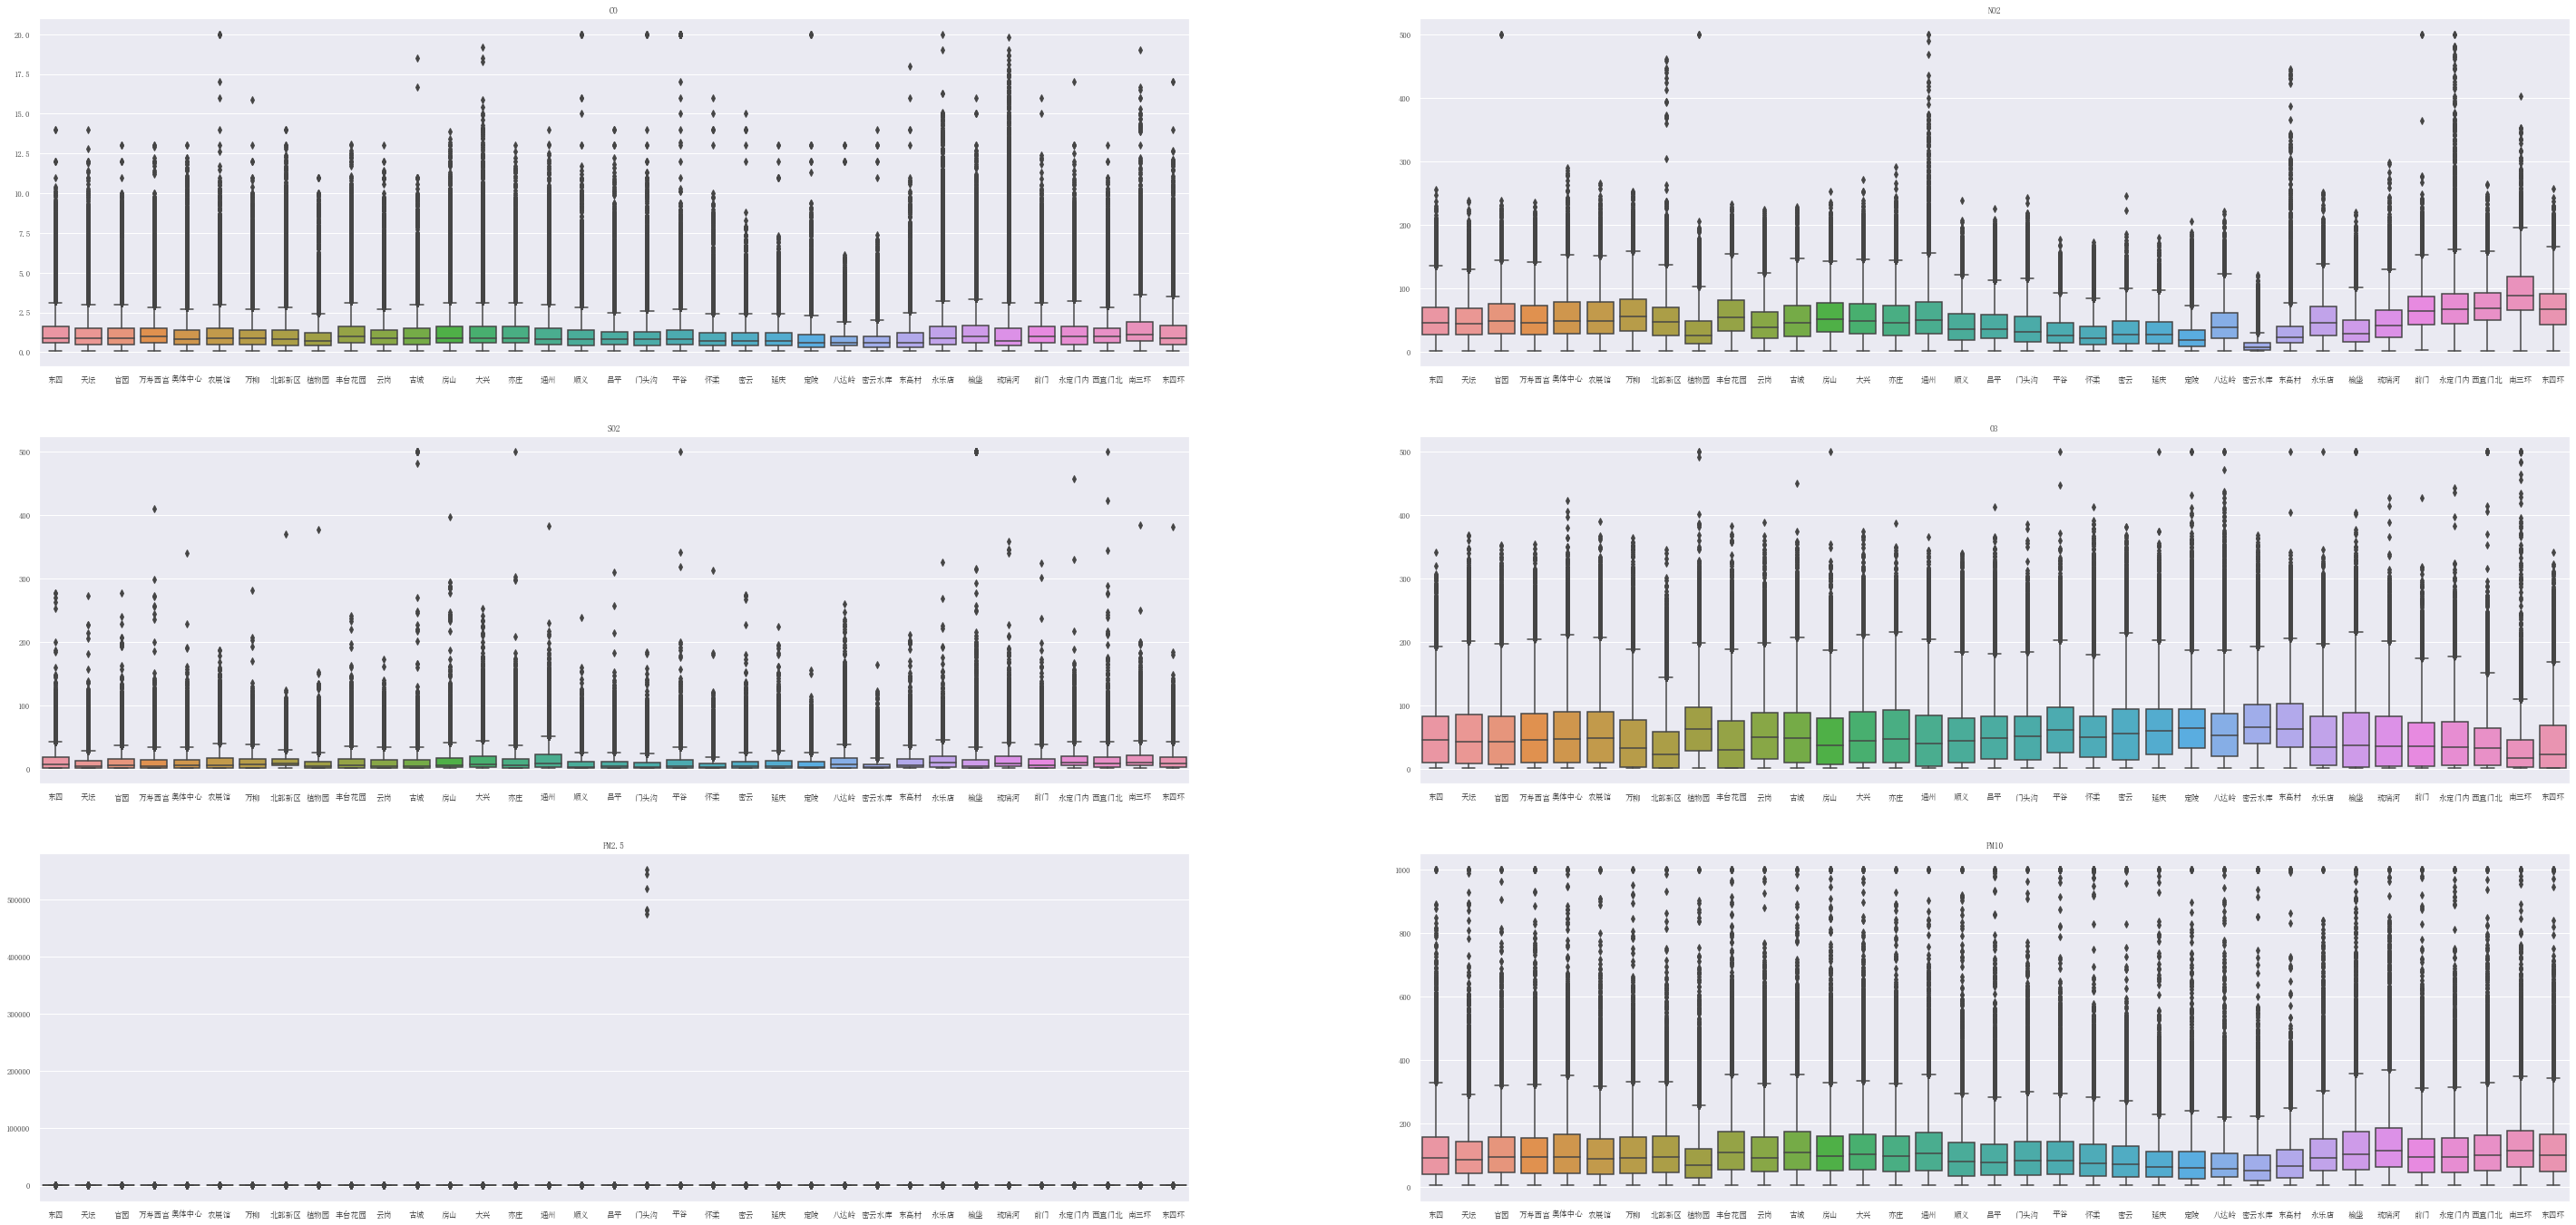

In [484]:
sns.set(rc={'figure.figsize':(50,24)},font="SimSun",font_scale=0.8)
f, axes = plt.subplots(3, 2)
sns.boxplot(data=train[train['type']=='CO'].drop(columns=['type']),ax=axes[0][0]);axes[0][0].set_title('CO');
sns.boxplot(data=train[train['type']=='NO2'].drop(columns=['type']),ax=axes[0][1]);axes[0][1].set_title('NO2');
sns.boxplot(data=train[train['type']=='SO2'].drop(columns=['type']),ax=axes[1][0]);axes[1][0].set_title('SO2');
sns.boxplot(data=train[train['type']=='O3'].drop(columns=['type']),ax=axes[1][1]);axes[1][1].set_title('O3');
sns.boxplot(data=train[train['type']=='PM2.5'].drop(columns=['type']),ax=axes[2][0]);axes[2][0].set_title('PM2.5');
sns.boxplot(data=train[train['type']=='PM10'].drop(columns=['type']),ax=axes[2][1]);axes[2][1].set_title('PM10');

- There is no obvious corrupted data except for PM2.5 at location **门头沟**.

In [495]:
train = train[~((train['type']=='PM2.5')&(train['门头沟']>2000))]

Text(0.5, 1.0, 'PM2.5')

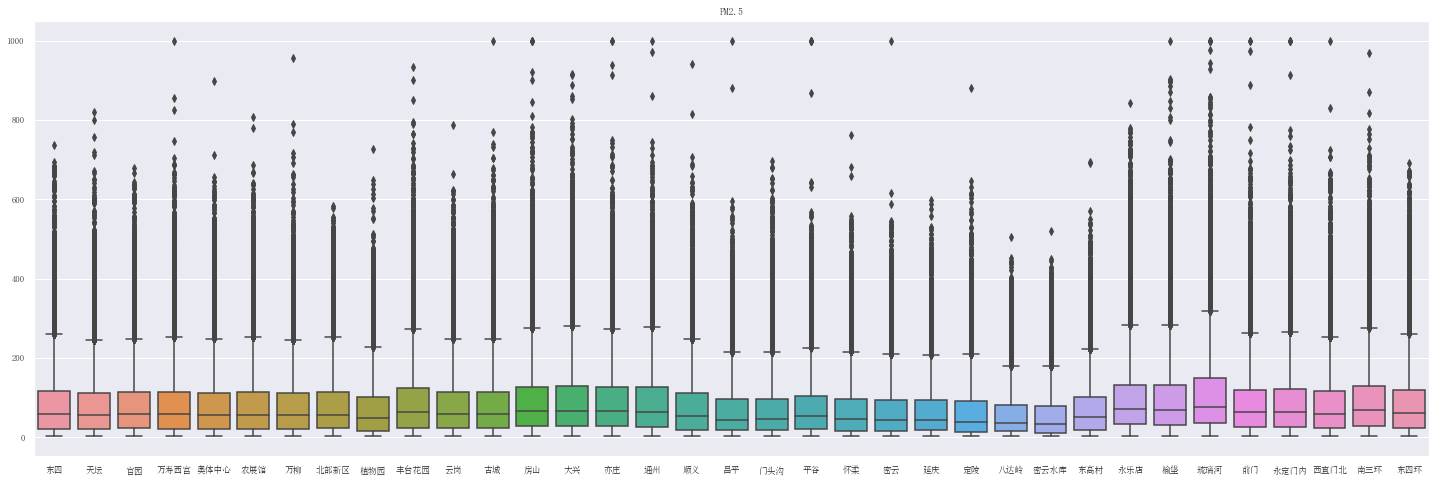

In [497]:
sns.set(rc={'figure.figsize':(25,8)},font="SimSun",font_scale=0.8)
sns.boxplot(data=train[train['type']=='PM2.5'].drop(columns=['type'])).set_title('PM2.5')

After removing the obvious outliers, the plot looks more reasonable.

### Data Preprocessing

In [5]:
def preprocess(df):
    #convert date and hour columns into a Datetime index
    df['Datetime'] = pd.to_datetime(df['date'],format='%Y%m%d')+pd.to_timedelta(df['hour'].astype(int), unit='H')
    df = df.set_index('Datetime')
    df = df.drop(columns=['date','hour'])
    #remove AQI and all pollutants with suffix '_24h'
    pollutant = set(df.type)
    pollutant.remove('AQI')
    pollutant = [p for p in pollutant if '24h' not in p]
    df = df.loc[df['type'].isin(pollutant)]
    return df

In [6]:
train = preprocess(train)
test = preprocess(test)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 146886 entries, 2014-01-01 00:00:00 to 2016-12-29 09:00:00
Data columns (total 36 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   type    146886 non-null  object 
 1   东四      134533 non-null  float64
 2   天坛      133571 non-null  float64
 3   官园      135563 non-null  float64
 4   万寿西宫    135041 non-null  float64
 5   奥体中心    132138 non-null  float64
 6   农展馆     135112 non-null  float64
 7   万柳      134600 non-null  float64
 8   北部新区    131752 non-null  float64
 9   植物园     131265 non-null  float64
 10  丰台花园    135051 non-null  float64
 11  云岗      136554 non-null  float64
 12  古城      136680 non-null  float64
 13  房山      133368 non-null  float64
 14  大兴      134462 non-null  float64
 15  亦庄      133128 non-null  float64
 16  通州      133876 non-null  float64
 17  顺义      130713 non-null  float64
 18  昌平      135754 non-null  float64
 19  门头沟     135774 non-null  float64
 20  平谷      133371

We have data from 35 different locations. For each location, there are a certain number of missing values. \
We will first pick up one location for exploratory analysis and initial modeling. Here we choose the location with least number of missing values in PM2.5.\
Location **万柳** is chosen under this criteria. 

In [8]:
train.loc[train['type']=='PM2.5'].isna().sum()

type       0
东四       771
天坛       879
官园       716
万寿西宫     917
奥体中心    1048
农展馆      798
万柳       595
北部新区    1323
植物园     1694
丰台花园    1025
云岗       808
古城       696
房山       772
大兴      1017
亦庄       842
通州      1226
顺义       833
昌平       932
门头沟      966
平谷       874
怀柔       908
密云       815
延庆       778
定陵       881
八达岭     3317
密云水库    1328
东高村     1120
永乐店     1203
榆垡      2318
琉璃河     1508
前门      1983
永定门内     820
西直门北    1445
南三环     1711
东四环     1204
dtype: int64

In [323]:
subset = train.loc[:,['type','万柳']]
subset = subset.pivot_table(values='万柳', index=[subset.index], columns='type').rename_axis(None,axis=1).reset_index().set_index('Datetime')

Since this is a time series problem, we would like the data as continous as possible. Therefore to handle missing data, we use certain imputation method. \
We first notice that there are a few missing dates/hours in our sample. Let's first fill in the missing periods. 

In [324]:
sample_periods = len(subset.index)
real_periods = len(pd.date_range(start=subset.index[0], end=subset.index[-1],freq='H'))
print(f'Our data has {sample_periods} periods available for 万柳, while time spanning from {subset.index[0]} to {subset.index[-1]} should have {real_periods} hours. There are {real_periods-sample_periods} periods missing.'  )

Our data has 25505 periods available for 万柳, while time spanning from 2014-01-01 00:00:00 to 2016-12-29 09:00:00 should have 26242 hours. There are 737 periods missing.


In [325]:
subset = subset.asfreq('h')

In [326]:
sample_periods = len(subset.index)
real_periods = len(pd.date_range(start=subset.index[0], end=subset.index[-1],freq='H'))
print(f'Our data now has {sample_periods} periods available for 万柳, while time spanning from {subset.index[0]} to {subset.index[-1]} should have {real_periods} hours. There are {real_periods-sample_periods} periods missing.'  )

Our data now has 26242 periods available for 万柳, while time spanning from 2014-01-01 00:00:00 to 2016-12-29 09:00:00 should have 26242 hours. There are 0 periods missing.


We then use linear interpolation for imputation. We compare the data before and after imputation, and there is no significant difference between the two, especially for the dependent variable PM2.5. 

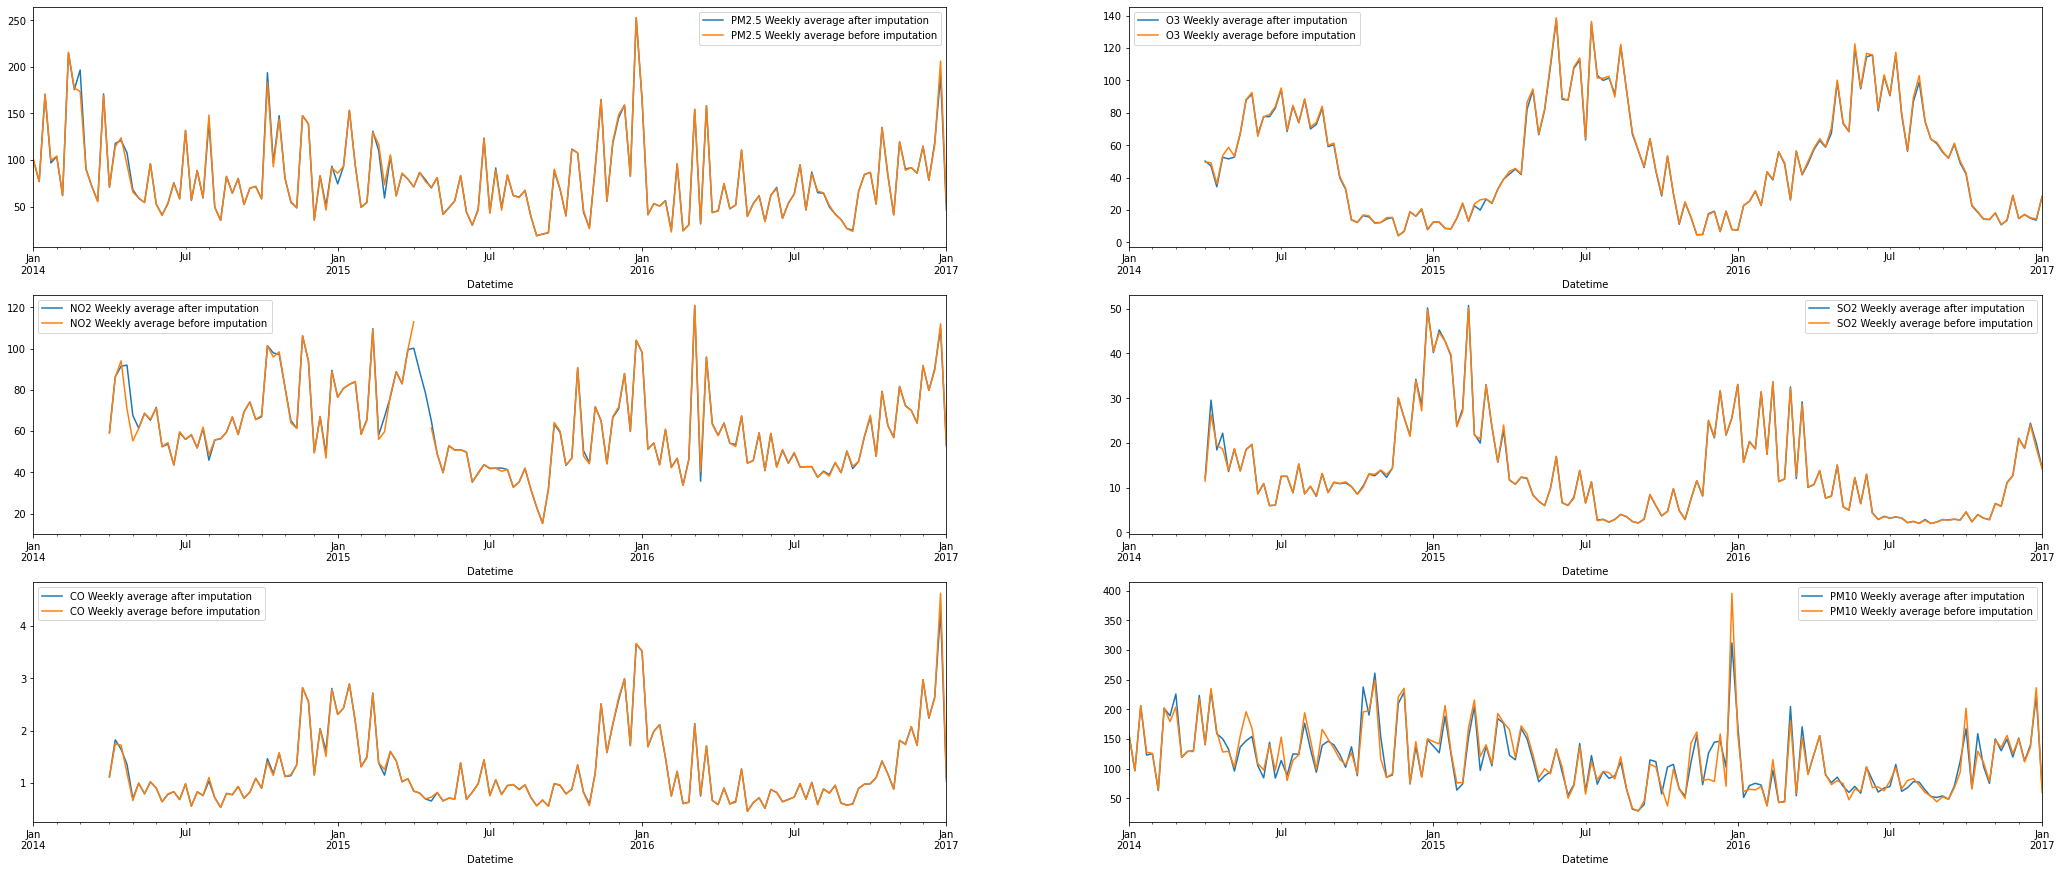

In [13]:
f, axes = plt.subplots(3, 2, figsize=(36,15))
subset["PM2.5"].interpolate(method='linear').resample("W").mean().plot(label="PM2.5 Weekly average after imputation", ax=axes[0][0])
subset["PM2.5"].resample("W").mean().plot(label="PM2.5 Weekly average before imputation",ax=axes[0][0])
axes[0][0].legend()
subset["NO2"].interpolate(method='linear').resample("W").mean().plot(label="NO2 Weekly average after imputation", ax=axes[1][0])
subset["NO2"].resample("W").mean().plot(label="NO2 Weekly average before imputation",ax=axes[1][0])
axes[1][0].legend()
subset["CO"].interpolate(method='linear').resample("W").mean().plot(label="CO Weekly average after imputation", ax=axes[2][0])
subset["CO"].resample("W").mean().plot(label="CO Weekly average before imputation",ax=axes[2][0])
axes[2][0].legend()
subset["O3"].interpolate(method='linear').resample("W").mean().plot(label="O3 Weekly average after imputation", ax=axes[0][1])
subset["O3"].resample("W").mean().plot(label="O3 Weekly average before imputation",ax=axes[0][1])
axes[0][1].legend()
subset["SO2"].interpolate(method='linear').resample("W").mean().plot(label="SO2 Weekly average after imputation", ax=axes[1][1])
subset["SO2"].resample("W").mean().plot(label="SO2 Weekly average before imputation",ax=axes[1][1])
axes[1][1].legend()
subset["PM10"].interpolate(method='linear').resample("W").mean().plot(label="PM10 Weekly average after imputation", ax=axes[2][1])
subset["PM10"].resample("W").mean().plot(label="PM10 Weekly average before imputation",ax=axes[2][1])
axes[2][1].legend()
plt.show()

In [327]:
subset = subset.interpolate(method = 'linear')

Before April 2014, there is no data for CO, NO2 and O3. In order to build a model with complete information, we only use data **after** that time. 


In [328]:
subset = subset.dropna()
subset.head()

,CO,NO2,O3,PM10,PM2.5,SO2
Datetime,,,,,,
2014-04-02 12:00:00,1.0,61.0,95.0,13.0,66.0,15.0
2014-04-02 13:00:00,1.0,58.0,109.0,66.0,52.0,14.0
2014-04-02 14:00:00,1.0,58.0,121.0,125.0,65.0,16.0
2014-04-02 15:00:00,1.0,64.0,125.0,188.0,102.0,24.0
2014-04-02 16:00:00,2.0,67.0,129.0,157.0,108.0,30.0


### Exploratory Data Analysis

Before we fit a model, we would like to visualize the data to get some insight from it. First we use boxplots to display distribution of the data to get a better idea of how the data are spread out over hours, months and years. 

- There is no clear pattern for PM2.5 across 24 hours of a day. 
- For NO2 and O3 however, there seems to be a **cyclic pattern over days**. Thinking about the nature of the data, this makes sense. For example, NO2 level is higher in the morning and evening, and lower in the middle of the day, which could be driven by the exhaust emissions from motor vehicles. This suggests that we may need to take a 24-lag difference for those data. 

[Text(0.5, 0, 'Hours in day'), Text(0, 0.5, 'Concentration')]

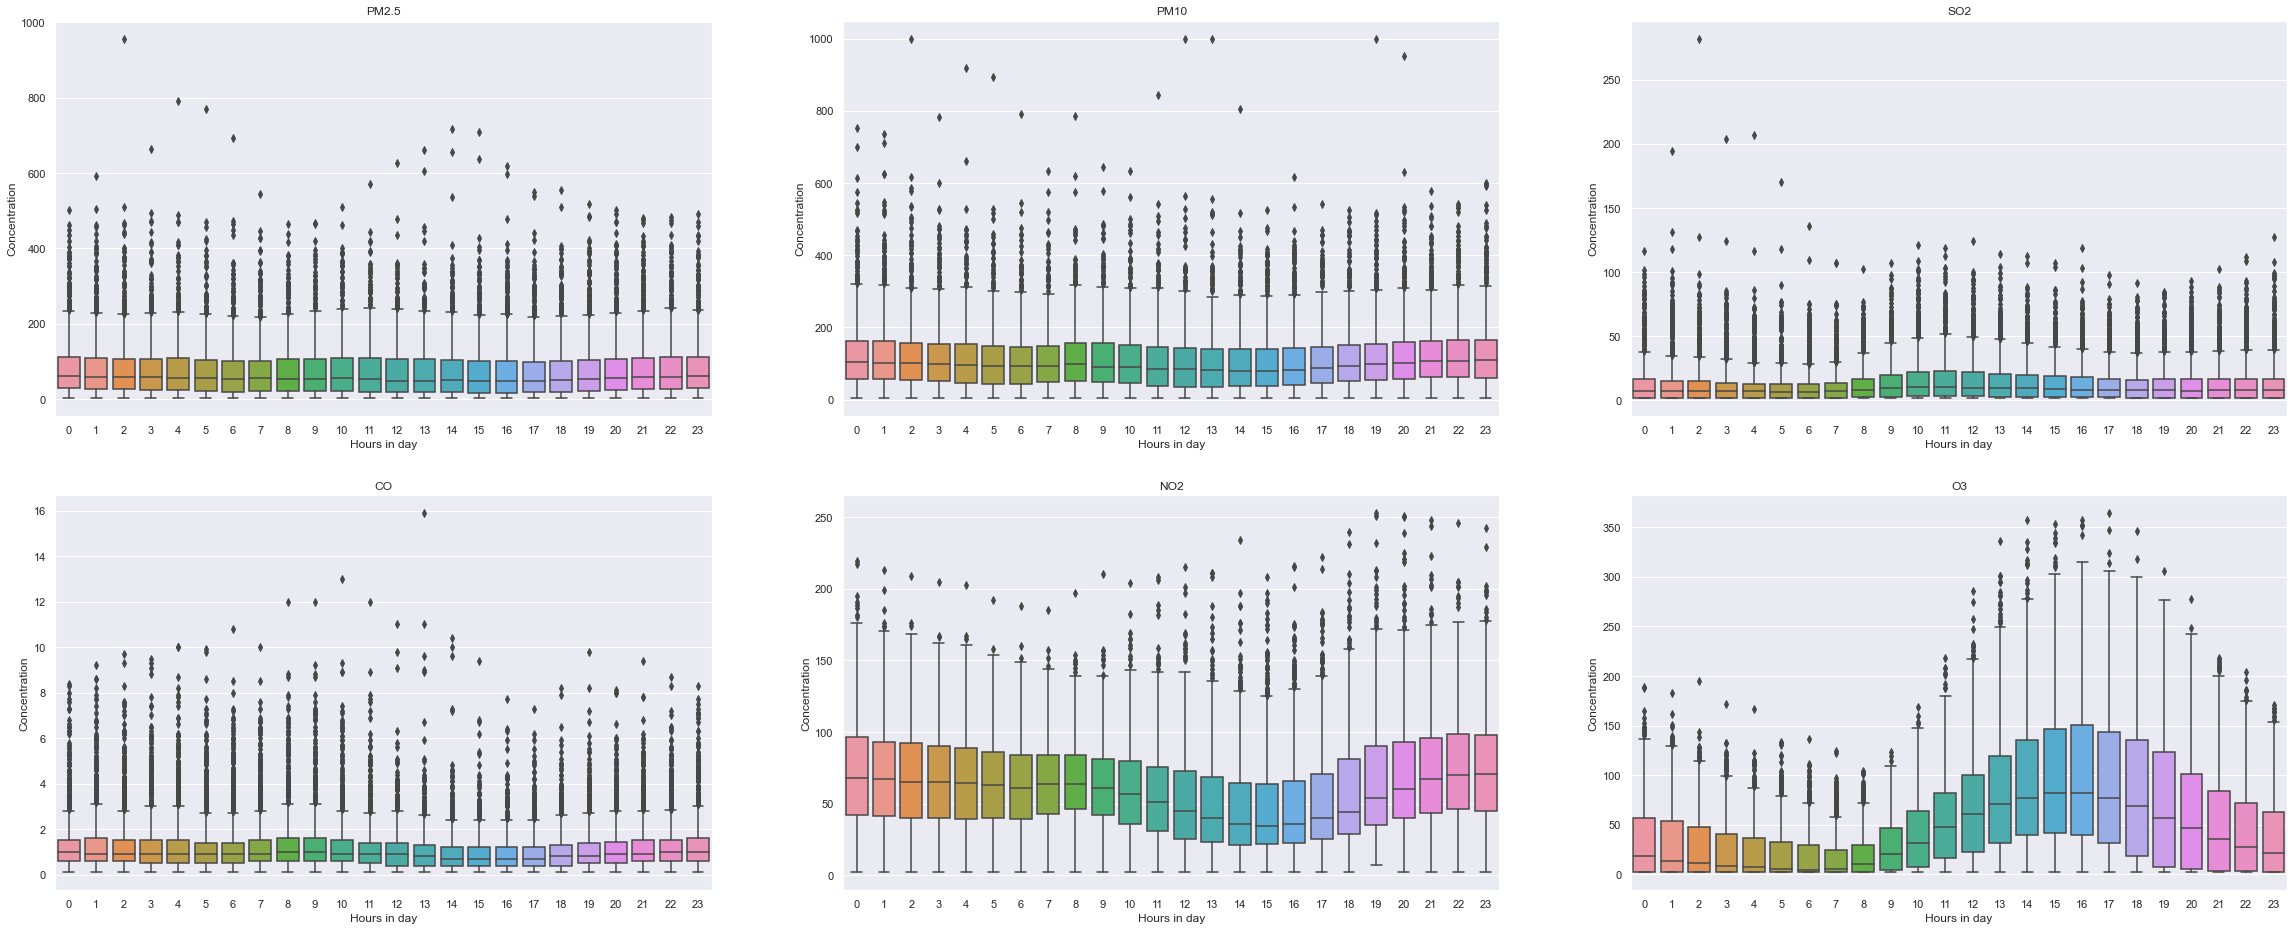

In [39]:
sns.set(rc={'figure.figsize':(40,16)})
f, axes = plt.subplots(2, 3)
sns.boxplot(x=subset.index.hour, y='PM2.5', data=subset, ax=axes[0][0]);axes[0][0].set_title('PM2.5');axes[0][0].set(xlabel='Hours in day',ylabel='Concentration')
sns.boxplot(x=subset.index.hour, y='PM10', data=subset, ax=axes[0][1]);axes[0][1].set_title('PM10');axes[0][1].set(xlabel='Hours in day',ylabel='Concentration')
sns.boxplot(x=subset.index.hour, y='SO2', data=subset, ax=axes[0][2]);axes[0][2].set_title('SO2');axes[0][2].set(xlabel='Hours in day',ylabel='Concentration')
sns.boxplot(x=subset.index.hour, y='CO', data=subset, ax=axes[1][0]);axes[1][0].set_title('CO');axes[1][0].set(xlabel='Hours in day',ylabel='Concentration')
sns.boxplot(x=subset.index.hour, y='NO2', data=subset, ax=axes[1][1]);axes[1][1].set_title('NO2');axes[1][1].set(xlabel='Hours in day',ylabel='Concentration')
sns.boxplot(x=subset.index.hour, y='O3', data=subset, ax=axes[1][2]);axes[1][2].set_title('O3');axes[1][2].set(xlabel='Hours in day',ylabel='Concentration')

- There is a clear **monthly pattern** for every pollutant. For example, PM2.5 level is lower in summer than it is in winter. This indicates that we could take month as a **categorical variable** or we could use **rolling window statistics** with a size of 720(24*30).

[Text(0.5, 0, 'Month'), Text(0, 0.5, 'Concentration')]

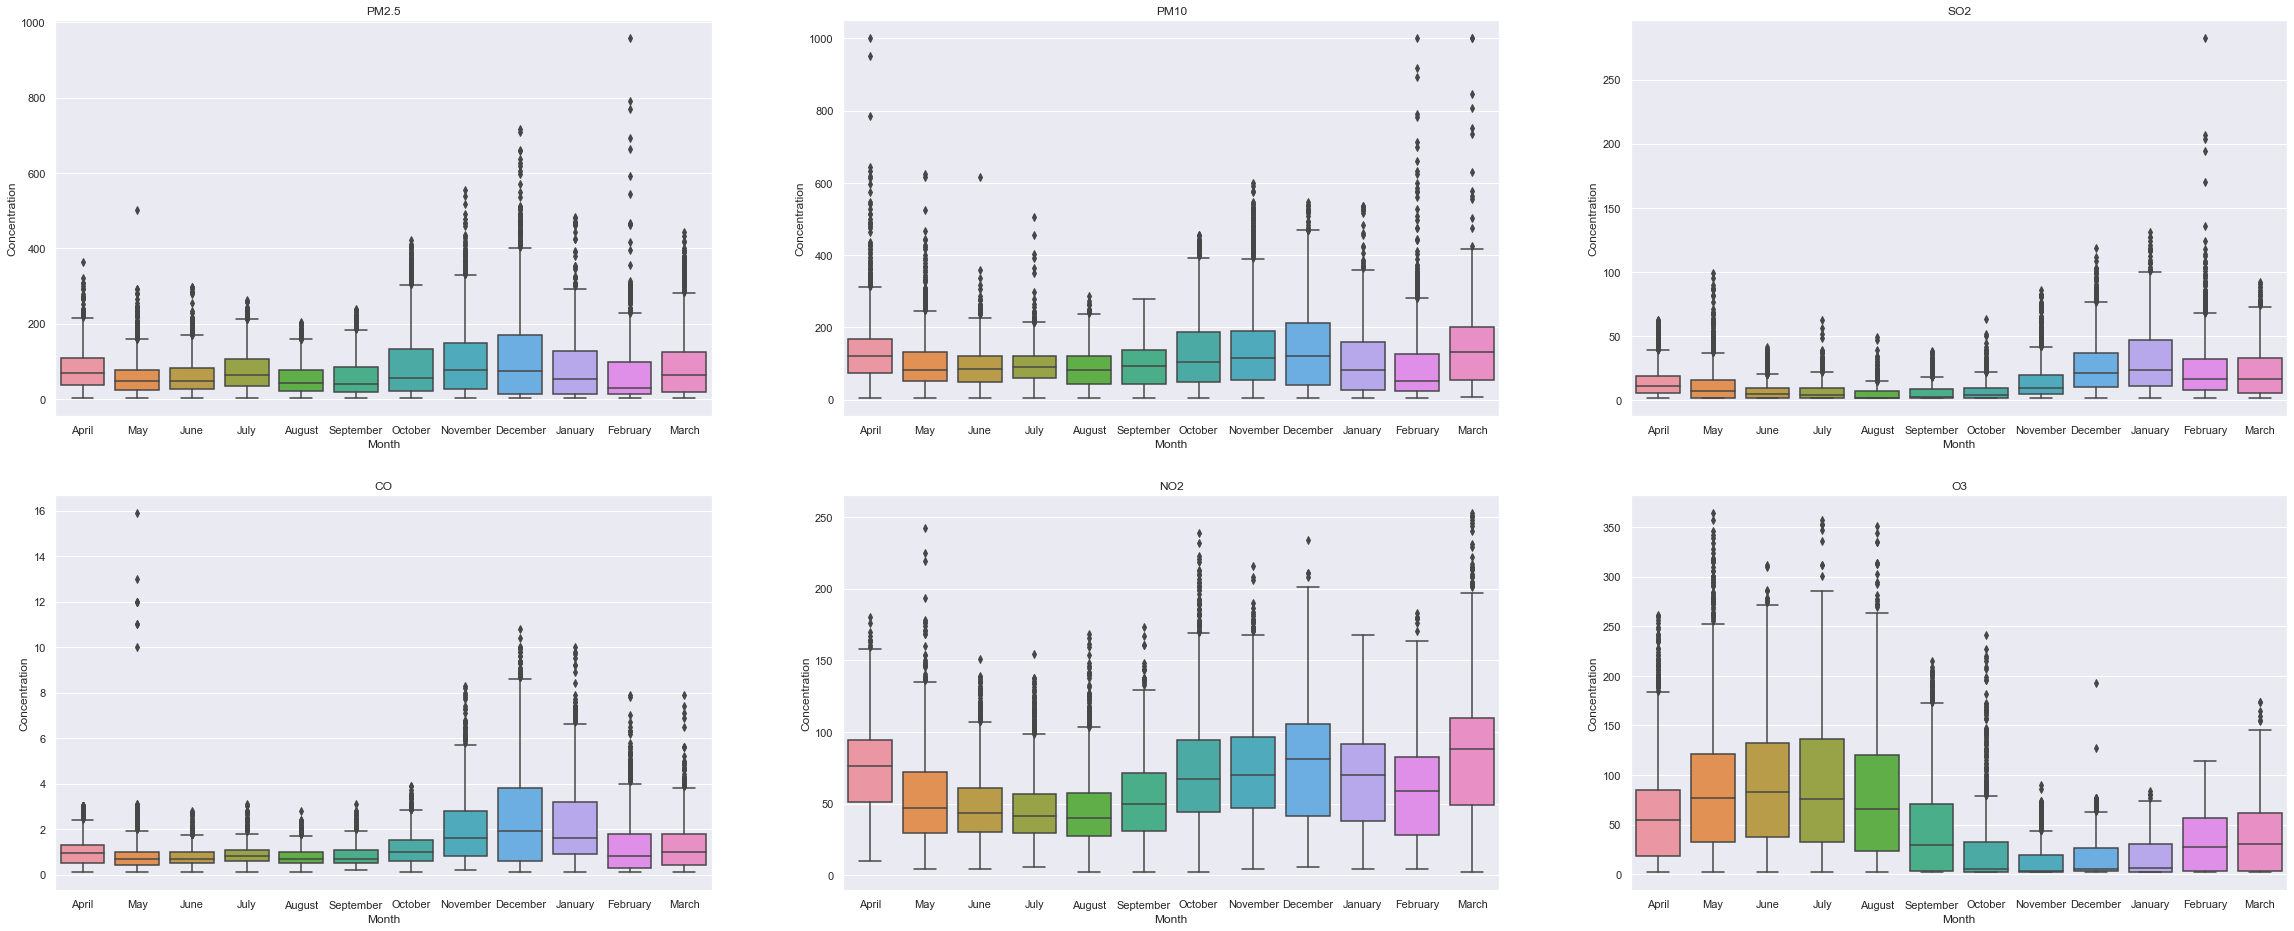

In [40]:
sns.set(rc={'figure.figsize':(40,16)})
f, axes = plt.subplots(2, 3)
sns.boxplot(x=subset.index.strftime('%B'), y='PM2.5', data=subset, ax=axes[0][0]);axes[0][0].set_title('PM2.5');axes[0][0].set(xlabel='Month',ylabel='Concentration')
sns.boxplot(x=subset.index.strftime('%B'), y='PM10', data=subset, ax=axes[0][1]);axes[0][1].set_title('PM10');axes[0][1].set(xlabel='Month',ylabel='Concentration')
sns.boxplot(x=subset.index.strftime('%B'), y='SO2', data=subset, ax=axes[0][2]);axes[0][2].set_title('SO2');axes[0][2].set(xlabel='Month',ylabel='Concentration')
sns.boxplot(x=subset.index.strftime('%B'), y='CO', data=subset, ax=axes[1][0]);axes[1][0].set_title('CO');axes[1][0].set(xlabel='Month',ylabel='Concentration')
sns.boxplot(x=subset.index.strftime('%B'), y='NO2', data=subset, ax=axes[1][1]);axes[1][1].set_title('NO2');axes[1][1].set(xlabel='Month',ylabel='Concentration')
sns.boxplot(x=subset.index.strftime('%B'), y='O3', data=subset, ax=axes[1][2]);axes[1][2].set_title('O3');axes[1][2].set(xlabel='Month',ylabel='Concentration')

- Some pollutants such as PM2.5 and PM10 also follows a **downward trend** over years. This makes sense since the city is taking actions to reduce PM2.5 levels for a better air quality. This also suggest that we may need to take a lag-1 differnce to remove the trend. 

[Text(0.5, 0, 'Year'), Text(0, 0.5, 'Concentration')]

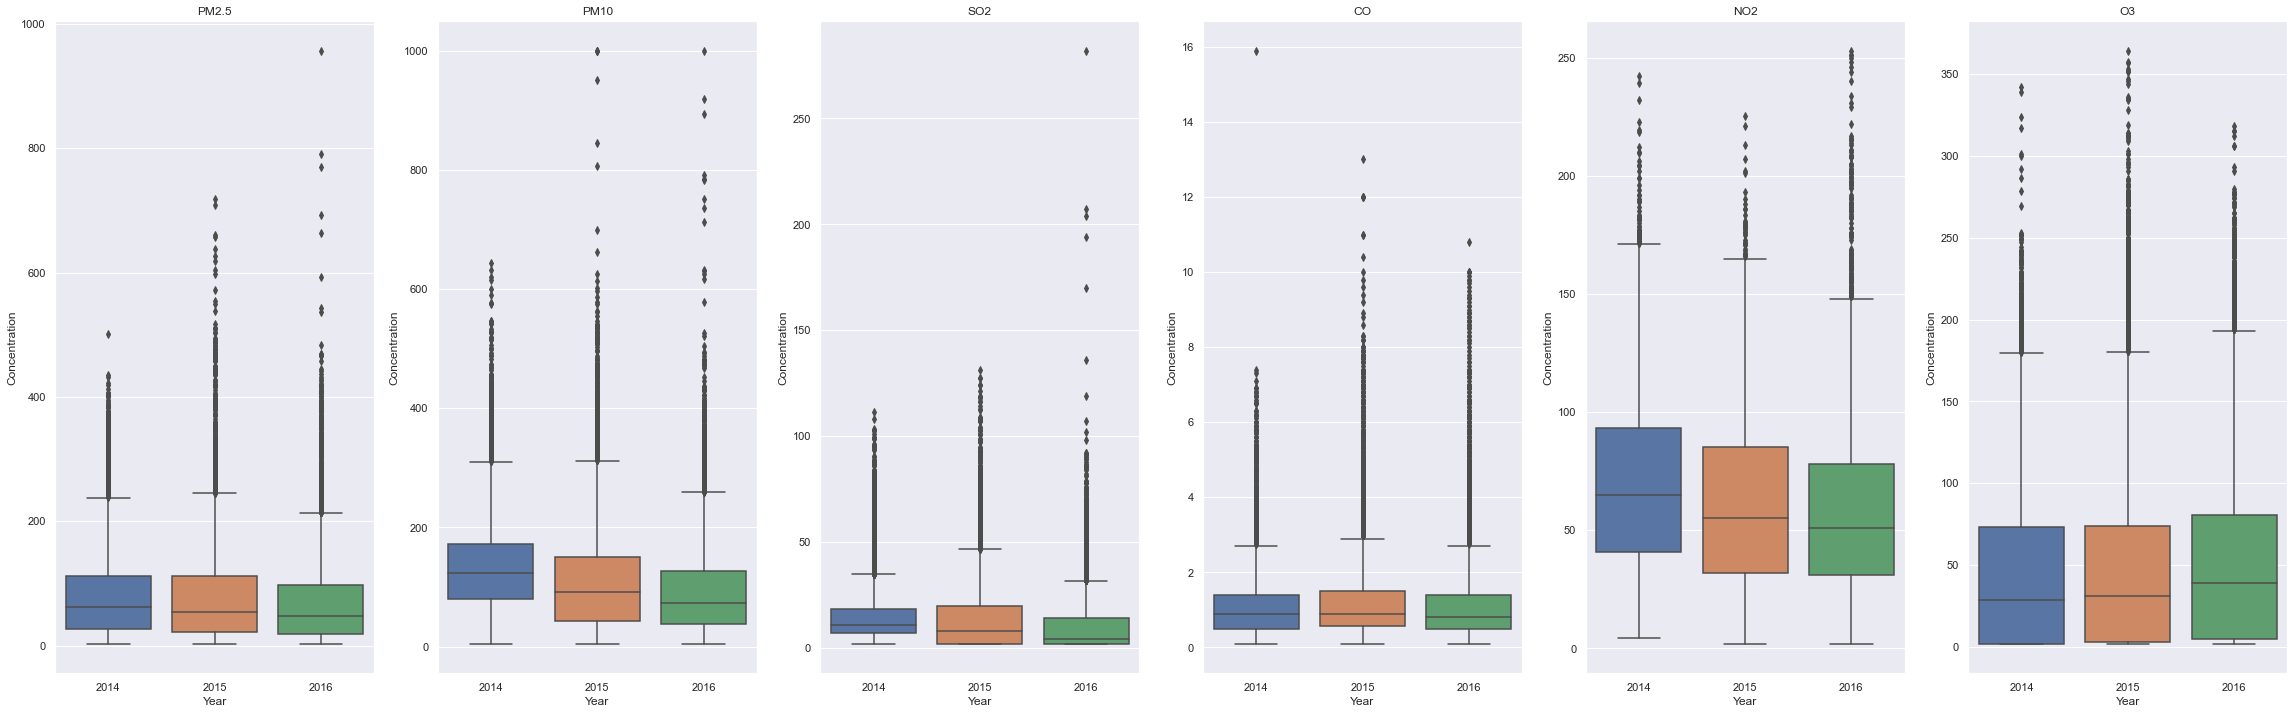

In [41]:
sns.set(rc={'figure.figsize':(40,12)})
f, axes = plt.subplots(1, 6)
sns.boxplot(x=subset.index.year, y='PM2.5', data=subset, ax=axes[0]);axes[0].set_title('PM2.5');axes[0].set(xlabel='Year',ylabel='Concentration')
sns.boxplot(x=subset.index.year, y='PM10', data=subset, ax=axes[1]);axes[1].set_title('PM10');axes[1].set(xlabel='Year',ylabel='Concentration')
sns.boxplot(x=subset.index.year, y='SO2', data=subset, ax=axes[2]);axes[2].set_title('SO2');axes[2].set(xlabel='Year',ylabel='Concentration')
sns.boxplot(x=subset.index.year, y='CO', data=subset, ax=axes[3]);axes[3].set_title('CO');axes[3].set(xlabel='Year',ylabel='Concentration')
sns.boxplot(x=subset.index.year, y='NO2', data=subset, ax=axes[4]);axes[4].set_title('NO2');axes[4].set(xlabel='Year',ylabel='Concentration')
sns.boxplot(x=subset.index.year, y='O3', data=subset, ax=axes[5]);axes[5].set_title('O3');axes[5].set(xlabel='Year',ylabel='Concentration')

We now turn to ACF and PACF plots to better diagonize trend and seaonality.

In [48]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

- We observe a clear seasonal component at daily lag at 24,48, etc. for CO, NO2 and O3, which is consistent with what we found before. Potentially SO2 also has a cycle. A **24th order difference** could be applied to those series. 
- The persistence of high values in ACF plot indicates that a **1-day difference** may be needed. 

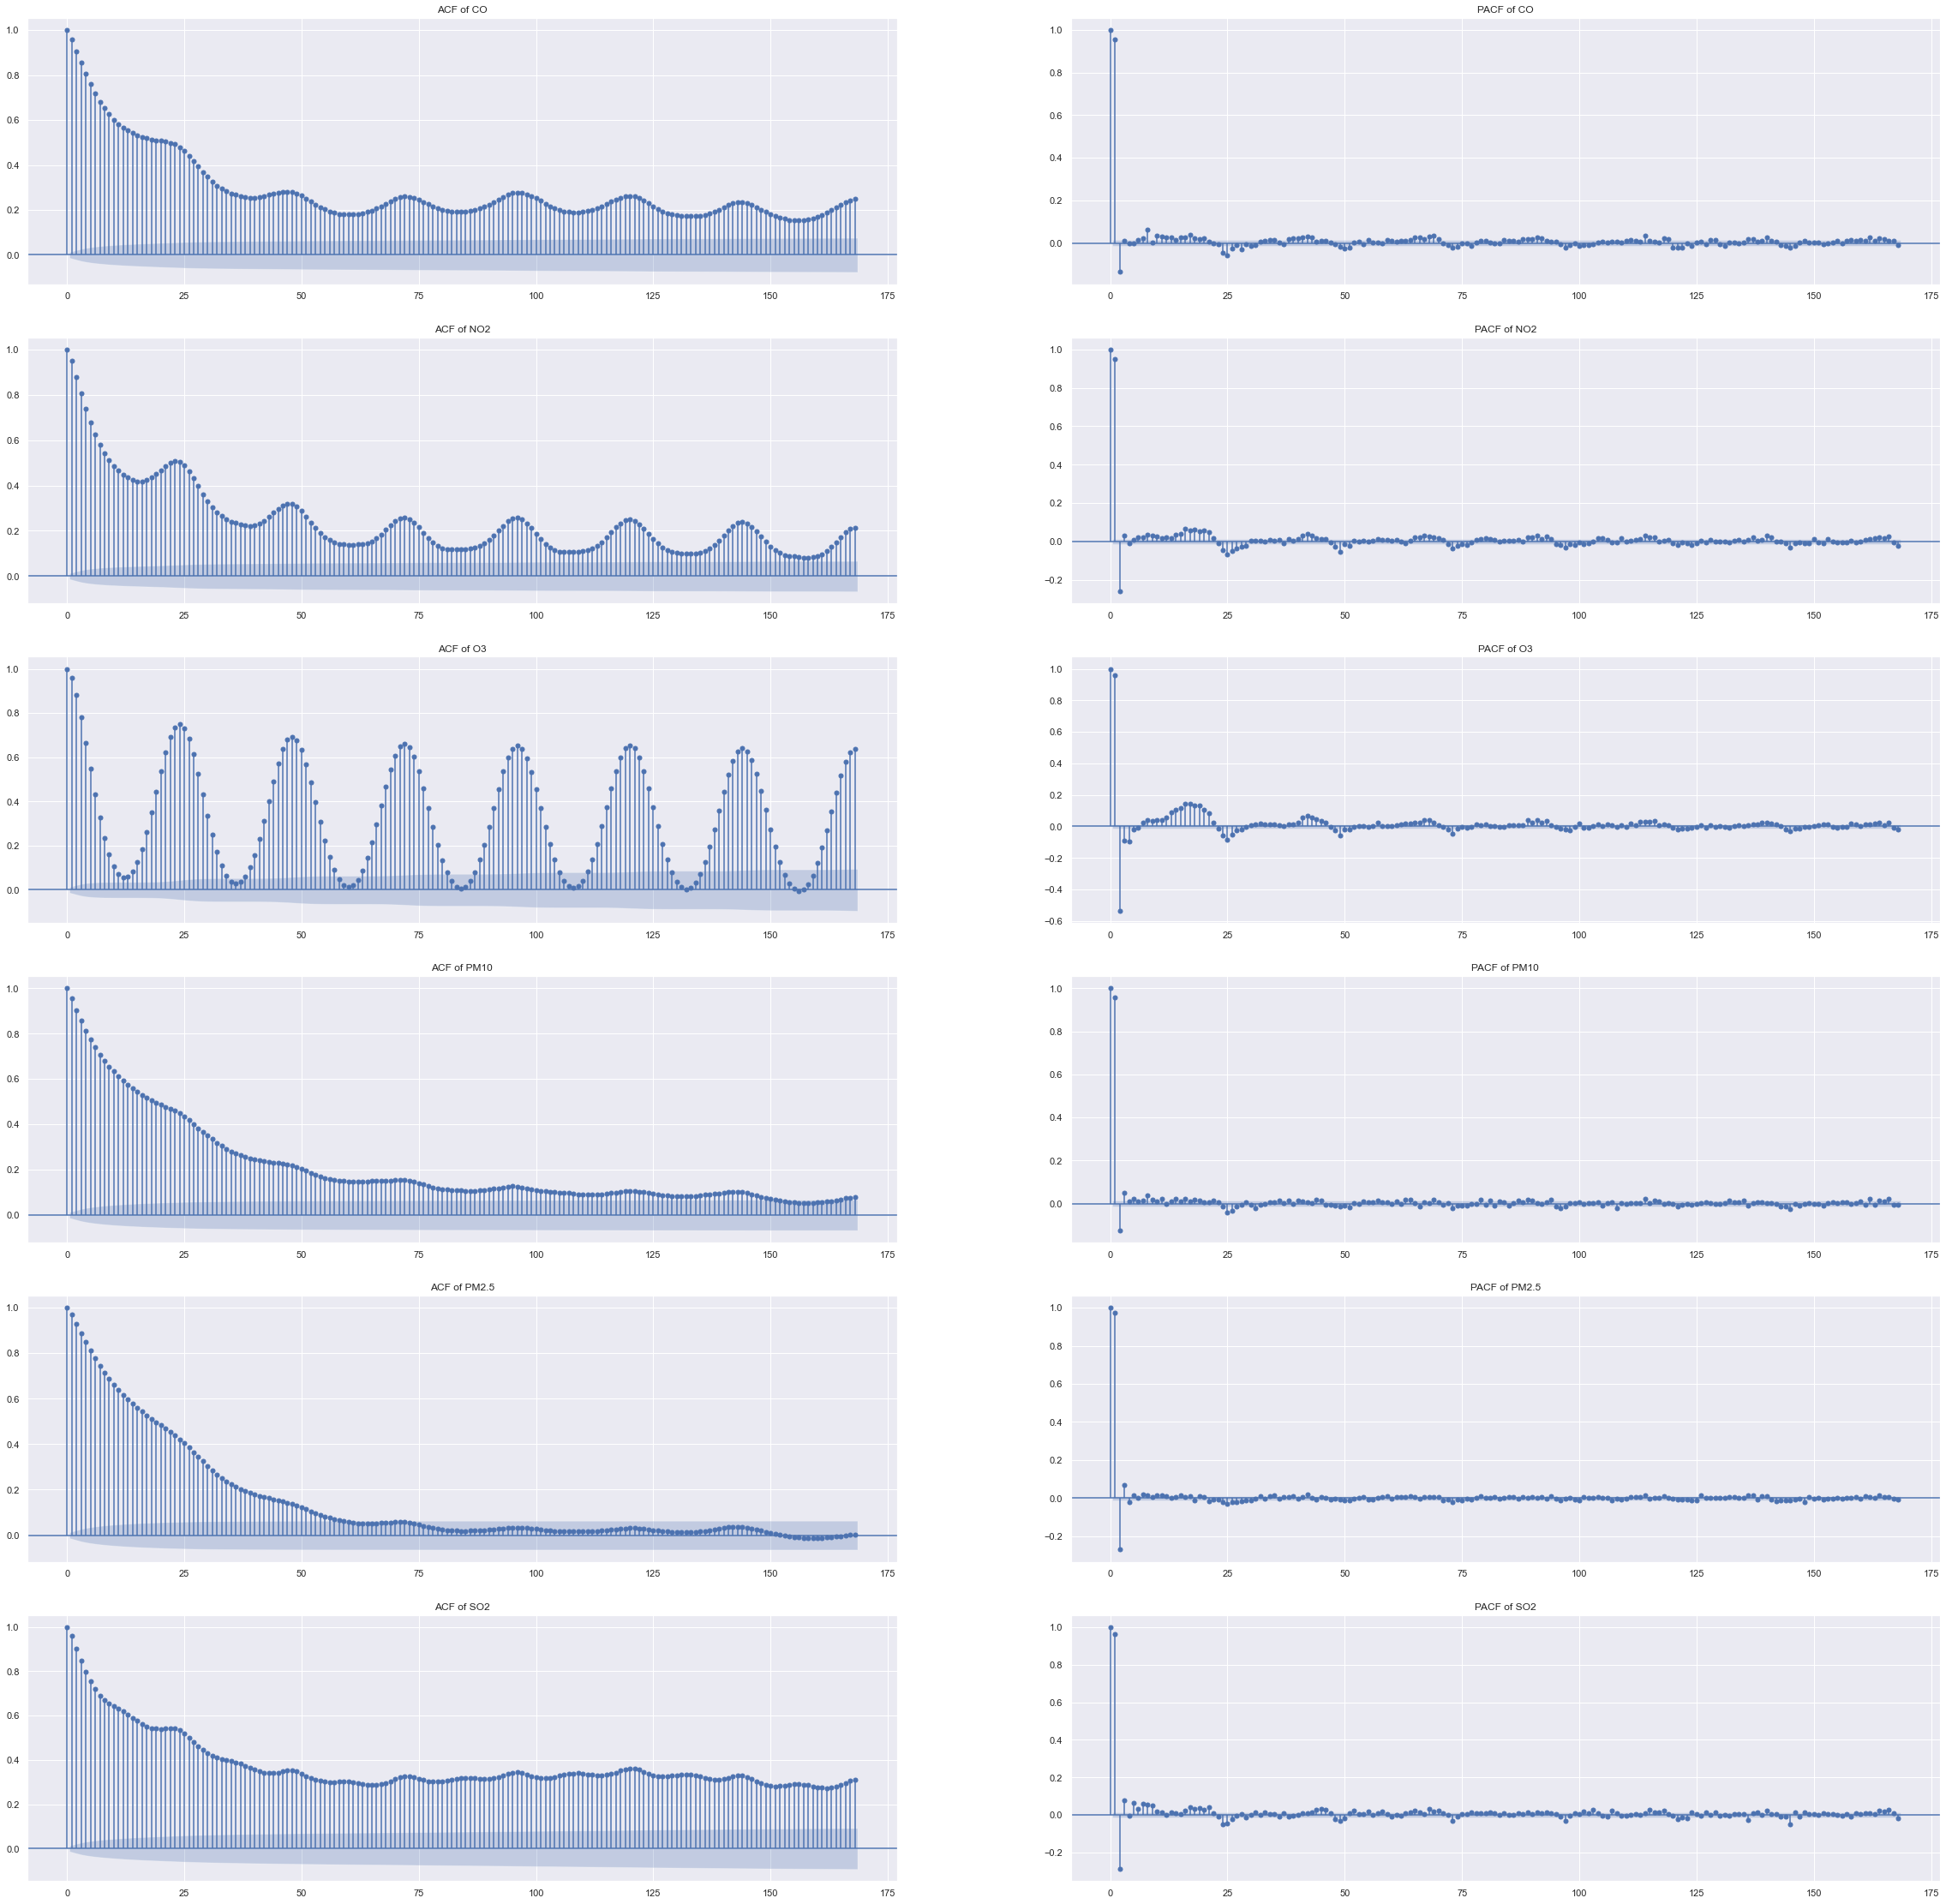

In [51]:
plt.rc("figure", figsize=(40,40))
f, axes = plt.subplots(6, 2)
for k,p in enumerate(subset.columns):
    plot_acf(subset[p],lags=24*7,ax=axes[k][0],title=f"ACF of {p}")
    plot_pacf(subset[p],lags=24*7,ax=axes[k][1],title=f"PACF of {p}")
plt.show()

In [350]:
subset_diff = subset.copy()
subset_diff["PM2.5"] = subset_diff["PM2.5"]-subset_diff["PM2.5"].shift(1)
subset_diff["PM10"] = subset_diff["PM10"]-subset_diff["PM10"].shift(1)
subset_diff["SO2"] = subset_diff["SO2"]-subset_diff["SO2"].shift(24)
subset_diff["SO2"] = subset_diff["SO2"]-subset_diff["SO2"].shift(1)
subset_diff["CO"] = subset_diff["CO"]-subset_diff["CO"].shift(24)
subset_diff["CO"] = subset_diff["CO"]-subset_diff["CO"].shift(1)
subset_diff["NO2"] = subset_diff["NO2"]-subset_diff["NO2"].shift(24)
subset_diff["NO2"] = subset_diff["NO2"]-subset_diff["NO2"].shift(1)
subset_diff["O3"] = subset_diff["O3"]-subset_diff["O3"].shift(24)
subset_diff["O3"] = subset_diff["O3"]-subset_diff["O3"].shift(1)
subset_diff = subset_diff.dropna()

- After proper differencing for each pollutant, trend and seasonality can be well explained.

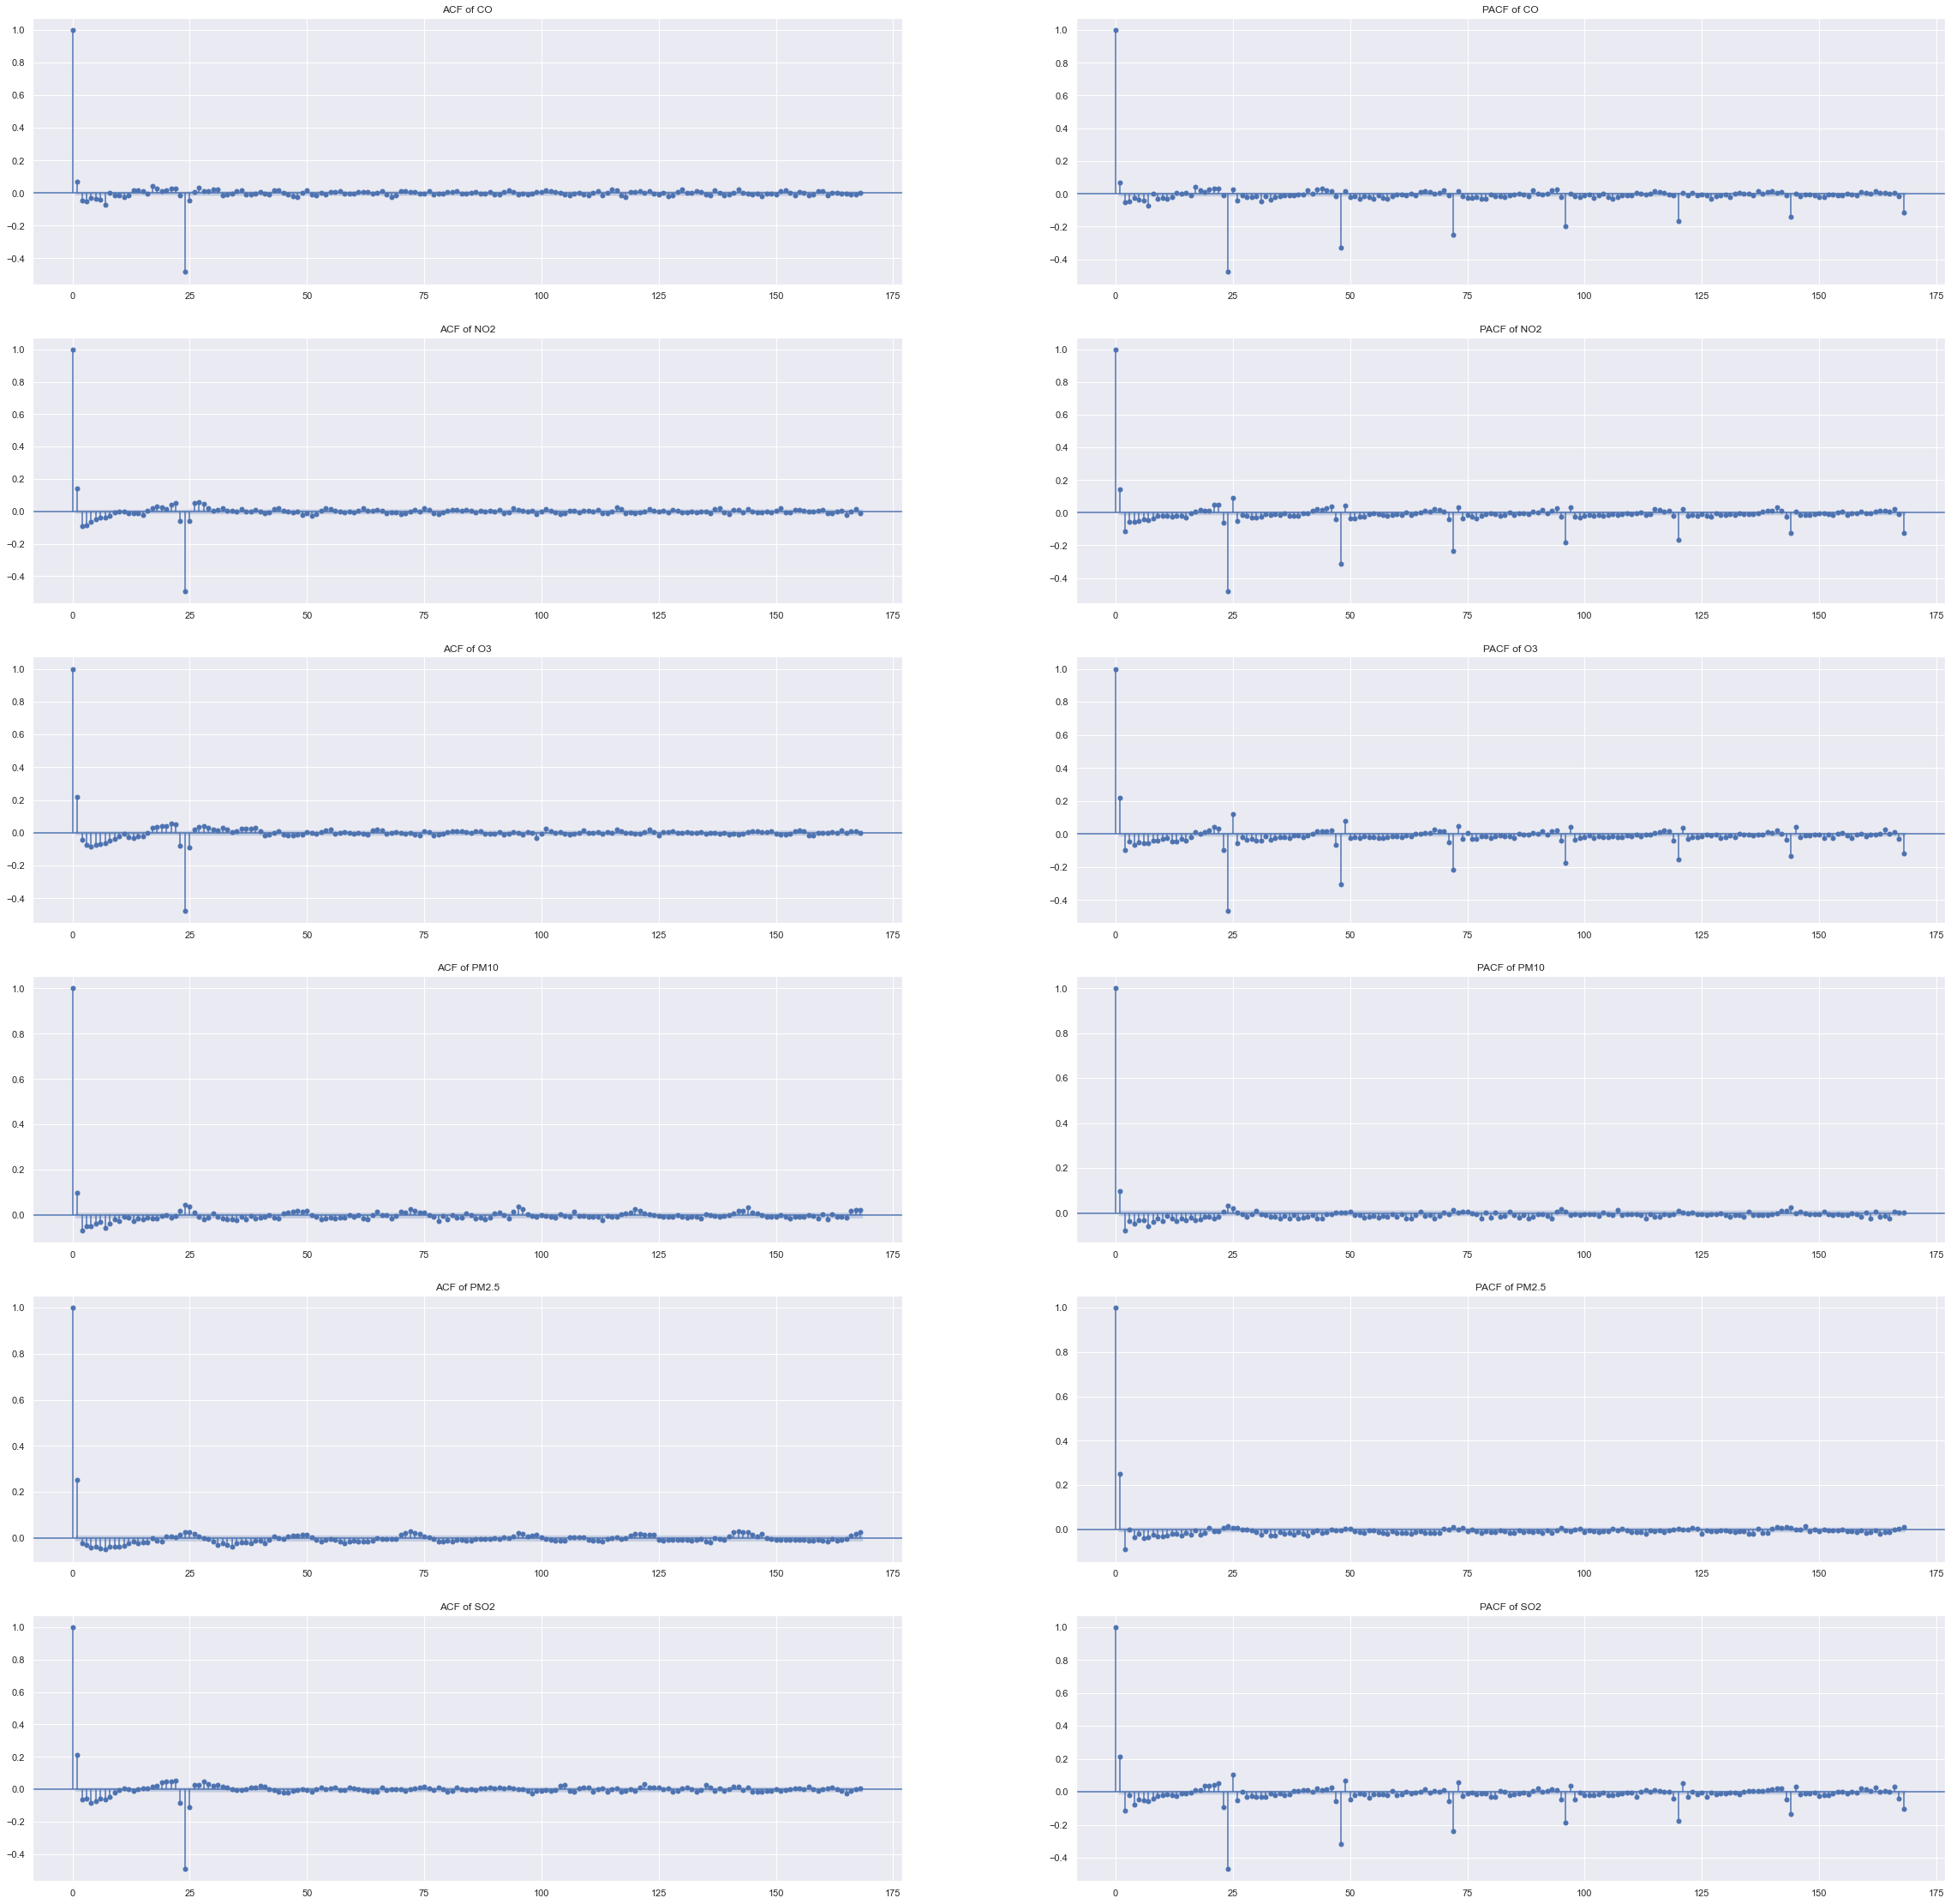

In [92]:
plt.rc("figure", figsize=(40,40))
f, axes = plt.subplots(6, 2)
for k,p in enumerate(subset_diff.columns):
    plot_acf(subset_diff[p],lags=24*7,ax=axes[k][0],title=f"ACF of {p}")
    plot_pacf(subset_diff[p],lags=24*7,ax=axes[k][1],title=f"PACF of {p}")
plt.show()

- The distribution of our data after transformation is as follows:

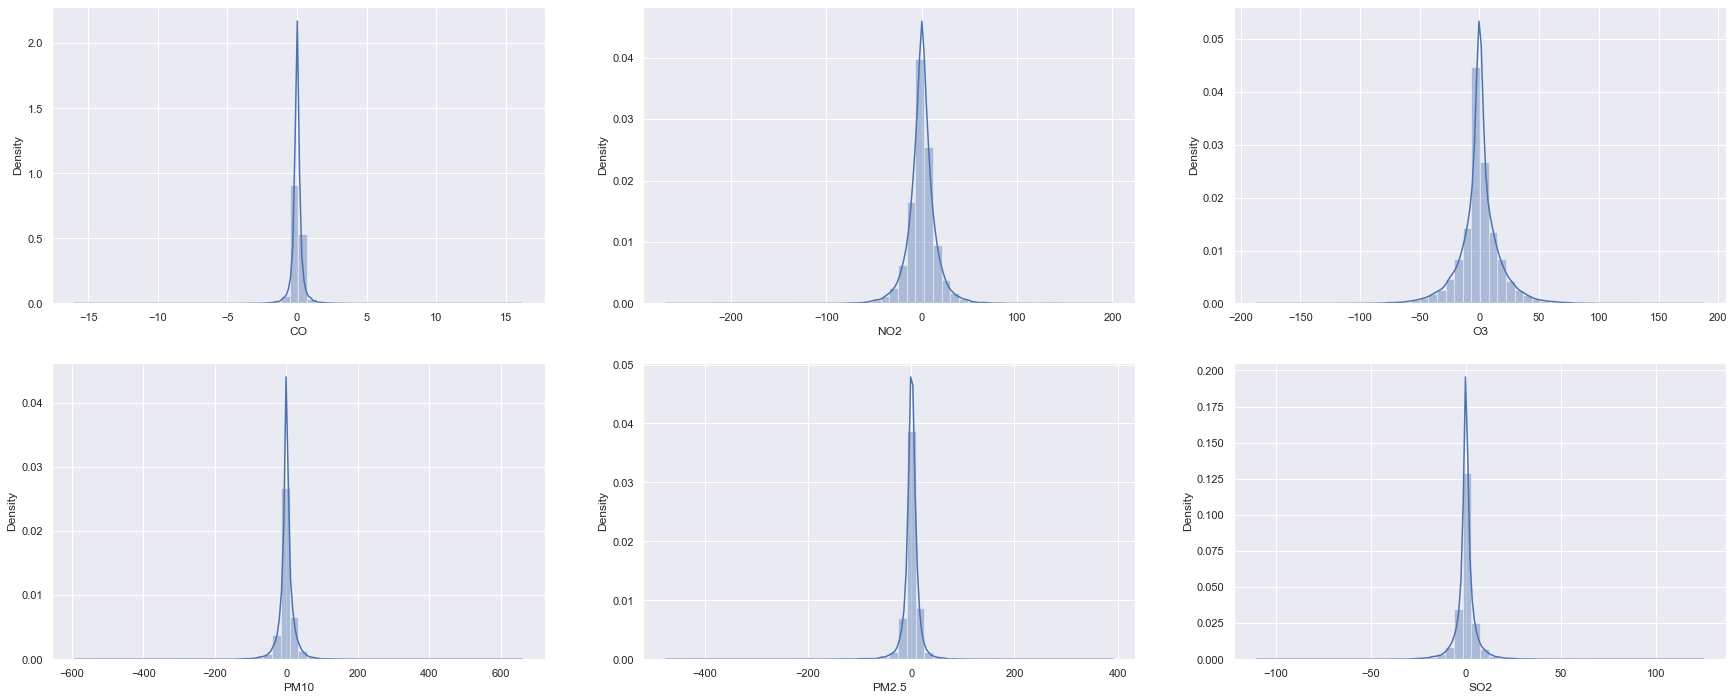

In [97]:
sns.set(rc={'figure.figsize':(30,12)})
n_rows=2
n_cols=3
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols)
for i, column in enumerate(subset_diff.columns):
    sns.distplot(subset_diff[column],ax=axes[i//n_cols,i%n_cols])

- We also plot scatter plot against each pair to get an idea of how the pollutants are correlated with each other. 

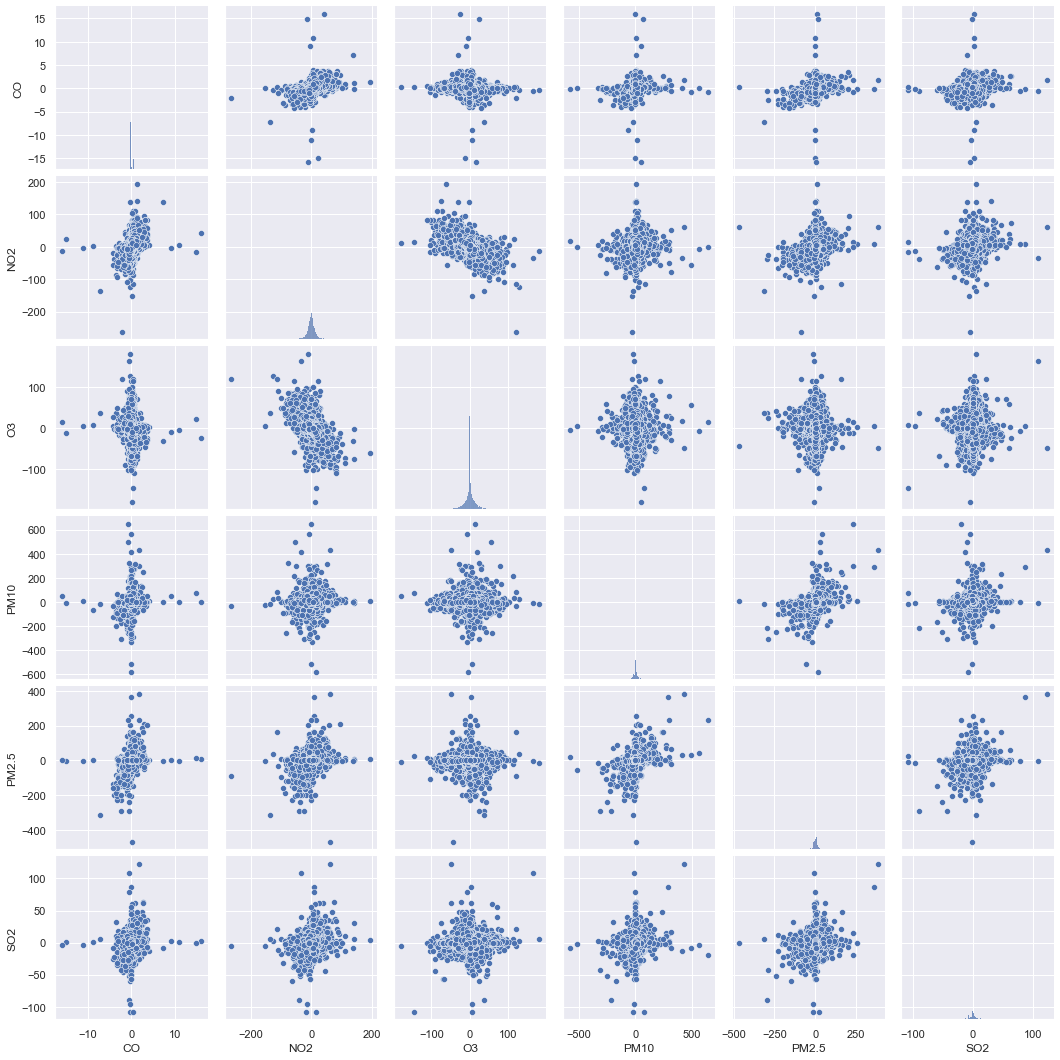

In [99]:
sns.pairplot(subset_diff)

### Naive model

We first present a naive model, where we just use the PM2.5 level from last hour to predict the level of next hour. Any model we develop later should at least beat this naive one.

In [114]:
import sklearn.metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

To evaluate the model, we use **root mean squared error(RMSE)** as the metrics. 

In [329]:
subset['prediction'] = subset['PM2.5'].shift(1)
subset.dropna(inplace=True)
print(f'In sample R^2 for naive model is {r2_score(subset["prediction"],subset["PM2.5"])}')
print(f'In sample RMSE for naive model is {np.sqrt(mean_squared_error(subset["prediction"],subset["PM2.5"]))}')

In sample R^2 for naive model is 0.9437328629865517
In sample RMSE for naive model is 18.095844214054974


In [331]:
testing = test.loc[:,['type','万柳']]
testing = testing.pivot_table(values='万柳', index=[testing.index], columns='type').rename_axis(None,axis=1).reset_index().set_index('Datetime')

testing = testing.asfreq('h')
testing = testing.interpolate(method = 'linear')
testing.dropna(inplace=True)

testing['prediction'] = testing['PM2.5'].shift(1)

In [334]:
testing.dropna(inplace=True)
print(f'Out of sample RMSE for naive model is {r2_score(testing["prediction"],testing["PM2.5"])}')
print(f'Out of sample RMSE for naive model is {np.sqrt(mean_squared_error(testing["prediction"],testing["PM2.5"]))}')

Out of sample RMSE for naive model is 0.9525087266116168
Out of sample RMSE for naive model is 17.86830857831343


### Build an ARIMA model

It turns out that the naive model actually gives a very reasonable prediction in terms of R squared and RMSE. Inspired by this result, we can move one step further and build an ARIMA model. \
First we need to define a proper cross validation framework. Here we use **time series splits**. The reason is that in each split, test indices must be higher than training indices, and thus **avoiding data leakage**. 
- Time Series Split illustration
    - fold 1 : training [1], test [2]
    - fold 2 : training [1 2], test [3]
    - fold 3 : training [1 2 3], test [4]
    - fold 4 : training [1 2 3 4], test [5]
    - fold 5 : training [1 2 3 4 5], test [6]

In [271]:
from sklearn.model_selection import TimeSeriesSplit

In [272]:
import statsmodels.api as sm

From the ACF plot and PACF plot of PM2.5, an **ARIMA(2,1,0)** model can be inferred.\
We conduct **ADF test to test stationarity** for the first order differenced series.

In [273]:
res = adfuller(subset_diff["PM2.5"],maxlag=24*7)

In [277]:
print(f'critical value is {res[0]}, p-value is {res[1]}')

critical value is -20.841270662051826, p-value is 0.0


According to test results, the series is stationary. \
We fit the model to the whole train data first.

In [279]:
arima_order = (2,1,0)
model = sm.tsa.statespace.SARIMAX(subset["PM2.5"],order=arima_order)
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                24044
Model:               SARIMAX(2, 1, 0)   Log Likelihood             -102849.212
Date:                Tue, 08 Feb 2022   AIC                         205704.424
Time:                        19:17:01   BIC                         205728.686
Sample:                    04-02-2014   HQIC                        205712.292
                         - 12-29-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2748      0.001    216.513      0.000       0.272       0.277
ar.L2         -0.0912      0.002    -55.964      0.000      -0.094      -0.088
sigma2       304.1337      0.474    641.689      0.0

#### Time series split cross validation

We now turn to cross validation to test model performance. 

In [335]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits)
arima_order = (2,1,0)
predicted = pd.DataFrame()
rmse = []
test_predictions = pd.DataFrame(np.zeros(testing.shape[0]),index=testing.index, columns=['prediction'])

for fold,(train_index, test_index) in enumerate(tscv.split(subset)):
    y_train = subset.loc[subset.index[train_index],"PM2.5"]
    y_test = subset.loc[subset.index[test_index],"PM2.5"]
    model = sm.tsa.statespace.SARIMAX(y_train,order=arima_order)
    fitted = model.fit()
    
    model = sm.tsa.statespace.SARIMAX(y_test, order=arima_order, )
    res = model.filter(fitted.params)
    y_predicted = res.get_prediction().predicted_mean
    y_predicted.iloc[0] = y_test.iloc[0]
    
    predicted = pd.concat([predicted,pd.DataFrame(y_predicted.values,index=subset.index[test_index], columns=['predicted'])])

    print(f"fold {fold+1}")
    print(f"RMSE is {np.sqrt(mean_squared_error(y_test,y_predicted))}")
    rmse.append(np.sqrt(mean_squared_error(y_test,y_predicted)))
    
    #Predict the test set       
    model = sm.tsa.statespace.SARIMAX(testing['PM2.5'],order=arima_order)
    res = model.filter(fitted.params)
    y_predicted = res.get_prediction().predicted_mean
    
    test_predictions['prediction'] += y_predicted / n_splits

C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\li

fold 1
RMSE is 19.06027562156176


C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


fold 2
RMSE is 15.736301372533156


C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


fold 3
RMSE is 17.623997933422597


C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


fold 4
RMSE is 18.226658966435604
fold 5
RMSE is 17.00926850321845


C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


In [336]:
testing['prediction'] = test_predictions['prediction']
testing = testing.iloc[1:,:]

In [337]:
print(f'In sample RMSE over folds is {np.mean(rmse)}')
print(f'Out of sample RMSE for ARIMA model is {np.sqrt(mean_squared_error(testing["prediction"],testing["PM2.5"]))}')

In sample RMSE over folds is 17.531300479434314
Out of sample RMSE for ARIMA model is 17.20172178061264


**We see that the model improves both in sample and out of sample RMSE.**

So far we have only considered using PM2.5 level itself to predict next hour level. We could of course add other pollutants as predictor variables. 
- In ARIMA model, we can specify those variables as exogenous variables. 
- To prevent data leakage, we will use the data from previous hour to predict next hour PM2.5 level **(no future data)**. 
- Also to ensure stationarity, we conduct appropriate differencing to the exogenous variables as discussed before. 

In [343]:
subset = pd.merge(subset_diff,subset['PM2.5'],left_index=True,right_index=True,suffixes=['','_y'])
subset['PM2.5'] = subset['PM2.5_y']
subset.drop(columns=['PM2.5_y'],inplace=True)

In [344]:
testing_diff = testing.copy()
testing_diff["PM2.5"] = testing_diff["PM2.5"]-testing_diff["PM2.5"].shift(1)
testing_diff["PM10"] = testing_diff["PM10"]-testing_diff["PM10"].shift(1)
testing_diff["SO2"] = testing_diff["SO2"]-testing_diff["SO2"].shift(24)
testing_diff["SO2"] = testing_diff["SO2"]-testing_diff["SO2"].shift(1)
testing_diff["CO"] = testing_diff["CO"]-testing_diff["CO"].shift(1)
testing_diff["CO"] = testing_diff["CO"]-testing_diff["CO"].shift(24)
testing_diff["NO2"] = testing_diff["NO2"]-testing_diff["NO2"].shift(24)
testing_diff["NO2"] = testing_diff["NO2"]-testing_diff["NO2"].shift(1)
testing_diff["O3"] = testing_diff["O3"]-testing_diff["O3"].shift(24)
testing_diff["O3"] = testing_diff["O3"]-testing_diff["O3"].shift(1)
testing_diff = testing_diff.dropna()

In [345]:
testing = pd.merge(testing_diff,testing['PM2.5'],left_index=True,right_index=True,suffixes=['','_y'])
testing['PM2.5'] = testing['PM2.5_y']
testing.drop(columns=['PM2.5_y'],inplace=True)

In [346]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits)
arima_order = (2,1,0)

predicted = pd.DataFrame()
rmse = []

test_predictions = pd.DataFrame(np.zeros(testing.shape[0]),index=testing.index, columns=['prediction'])

for fold,(train_index, test_index) in enumerate(tscv.split(subset)):
    y_train = subset.loc[subset.index[train_index],"PM2.5"]
    train_exog = subset.loc[subset.index[train_index],["PM10","SO2","CO","NO2",'O3']].shift(1).fillna(0)
    y_test = subset.loc[subset.index[test_index],"PM2.5"]
    test_exog =  subset.loc[subset.index[test_index],["PM10","SO2","CO","NO2",'O3']].shift(1).fillna(0)
    
    model = sm.tsa.statespace.SARIMAX(y_train,exog = train_exog,order=arima_order)
    fitted = model.fit()

    model = sm.tsa.statespace.SARIMAX(y_test,exog = test_exog, order=arima_order, )

    res = model.filter(fitted.params)
    y_predicted = res.get_prediction().predicted_mean
    y_predicted.iloc[0] = y_test.iloc[0]
    
    predicted = pd.concat([predicted,pd.DataFrame(y_predicted.values,index=subset.index[test_index], columns=['predicted'])])

    print(f"fold {fold+1}")
    print(f"RMSE is {np.sqrt(mean_squared_error(y_test,y_predicted))}")
    rmse.append(np.sqrt(mean_squared_error(y_test,y_predicted)))
    
    #Predict the test set       
    model = sm.tsa.statespace.SARIMAX(testing['PM2.5'],exog = testing[["PM10","SO2","CO","NO2",'O3']].shift(1).fillna(0),order=arima_order)
    res = model.filter(fitted.params)
    y_predicted = res.get_prediction().predicted_mean
    
    test_predictions['prediction'] += y_predicted / n_splits

C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


fold 1
RMSE is 19.012415291961343


C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


fold 2
RMSE is 15.669013174689503


C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


fold 3
RMSE is 17.607670524100026


C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


fold 4
RMSE is 18.126832577924368


C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


fold 5
RMSE is 16.889257042011682


In [347]:
testing['prediction'] = test_predictions['prediction']
testing = testing.iloc[1:,:]

In [348]:
print(f'In sample RMSE over folds is {np.mean(rmse)}')
print(f'Out of sample RMSE for ARIMA model is {np.sqrt(mean_squared_error(testing["prediction"],testing["PM2.5"]))}')

In sample RMSE over folds is 17.461037722137384
Out of sample RMSE for ARIMA model is 16.61365456745752


**The model gives us a better performance with additional predictor variables added.**

### More feature engineering

We now can move one step further and explore some nonlinear methods. \
Before doing that, let's first convert the time sereis into a more regular tabular data. To do that, we treat the PM2.5 level as the dependent variable, and for the predictor variable, we can use PM2.5 level from all previous periods, as well as other pollutant levels from previous periods, and some statistics like rolling window average based on those data. This opens up many doors for more complex feature engineering. \
Also we are free to perform regular K-fold cross validation in addition to time series split, which could be more flexible in certain situations. 

In [405]:
def process_one_location(df, location, take_log=True, n_lag=3):
    subset = df.loc[:,['type',location]]
    subset.sort_values(by = ['Datetime'])
    subset = subset.pivot_table(values=location, index=[df.index], columns='type').rename_axis(None,axis=1).reset_index().set_index('Datetime')

    subset_augmented = subset.asfreq('h')
    subset_augmented = subset_augmented.interpolate(method = 'linear')

    subset_augmented = subset_augmented.dropna()
    
    if take_log:
        subset_augmented = subset_augmented.apply(lambda x: np.log(x))
        
    subset_augmented = feature_engineering(subset_augmented,n_lag)
    
    subset_augmented =  subset_augmented.dropna()
    subset_augmented['location'] = location
    true_y =  subset_augmented[["PM2.5",'location']]
    subset_augmented['target'] = subset_augmented['PM2.5_diff']
    
    subset_augmented = subset_augmented.drop(columns=['PM2.5_diff','PM10_diff','SO2_diff','CO_diff','NO2_diff','O3_diff','PM2.5','PM10','SO2','CO','NO2','O3'])
    
    return subset_augmented, true_y
    
def feature_engineering(subset_augmented, n_lag):
    
    subset_augmented["PM2.5_diff"] = subset_augmented["PM2.5"]-subset_augmented["PM2.5"].shift(1)
    subset_augmented["PM10_diff"] = subset_augmented["PM10"]-subset_augmented["PM10"].shift(1)
    subset_augmented["SO2_diff"] = subset_augmented["SO2"]-subset_augmented["SO2"].shift(24)
    subset_augmented["SO2_diff"] = subset_augmented["SO2"]-subset_augmented["SO2"].shift(1)
    subset_augmented["CO_diff"] = subset_augmented["CO"]-subset_augmented["CO"].shift(24)
    subset_augmented["CO_diff"] = subset_augmented["CO"]-subset_augmented["CO"].shift(1)
    subset_augmented["NO2_diff"] = subset_augmented["NO2"]-subset_augmented["NO2"].shift(24)
    subset_augmented["NO2_diff"] = subset_augmented["NO2"]-subset_augmented["NO2"].shift(1)
    subset_augmented["O3_diff"] = subset_augmented["O3"]-subset_augmented["O3"].shift(24)
    subset_augmented["O3_diff"] = subset_augmented["O3"]-subset_augmented["O3"].shift(1)
    
    subset_augmented = create_lag(n_lag,subset_augmented)
    
    subset_augmented = calculate_rolling_stat(subset_augmented)
    
    return subset_augmented
        
def create_lag(n_lag, subset_augmented):
    col = ['PM2.5_diff','PM10_diff','SO2_diff','CO_diff','NO2_diff','O3_diff']
    for lag in range(1,n_lag+1):
        tmp = subset_augmented[col].shift(lag)
        tmp.columns=[f'{c}_lag_{lag}' for c in col]
        subset_augmented = pd.concat([subset_augmented,tmp],axis=1)
        
    return subset_augmented

def calculate_rolling_stat(res):
    for p in ['PM2.5_diff','PM10_diff','SO2_diff','CO_diff','NO2_diff','O3_diff']:
        res[f'{p}_daily_mean'] = res[p].rolling(24).mean()
        res[f'{p}_daily_median'] = res[p].rolling(24).median()
        res[f'{p}_daily_std'] = res[p].rolling(24).std()
        res[f'{p}_weekly_mean'] = res[p].rolling(24*7).mean()
        res[f'{p}_weekly_median'] = res[p].rolling(24*7).median()
        res[f'{p}_weekly_std'] = res[p].rolling(24*7).std()
        res[f'{p}_monthly_mean'] = res[p].rolling(24*30).mean()
        res[f'{p}_monthly_median'] = res[p].rolling(24*30).median()
        res[f'{p}_monthly_std'] = res[p].rolling(24*30).std()
    return res

The feature engineering techniques we are using are:
- Take appropriate difference
- Use differenced data from previous periods, marked as 'lag_1', 'lag_2' etc. 
- Calculate daily, weekly, montly rolling mean, median and standard deviation on the differenced data

Note that we will be predicting the change of PM2.5 level over days. There is one subtlety that the predicted PM2.5 level when transformed back can be nagative. One way to solve this is to take **log** transformation on original dataset. 

In [426]:
#In order to calcualte rolling window statistics, we append the last month data from training dataset to our test dataset.
test_new = pd.concat([train.iloc[train.index>'2016-12-01'],test])

In [502]:
subset,true_y = process_one_location(train,'万柳',take_log=True)
true_y['PM2.5_y'] = true_y['PM2.5'].shift(1) 
subset.drop(columns=['location'],inplace=True) #location will be used later

In [503]:
subset.head()

,PM2.5_diff_lag_1,PM10_diff_lag_1,SO2_diff_lag_1,CO_diff_lag_1,NO2_diff_lag_1,O3_diff_lag_1,PM2.5_diff_lag_2,PM10_diff_lag_2,SO2_diff_lag_2,CO_diff_lag_2,...,O3_diff_daily_mean,O3_diff_daily_median,O3_diff_daily_std,O3_diff_weekly_mean,O3_diff_weekly_median,O3_diff_weekly_std,O3_diff_monthly_mean,O3_diff_monthly_median,O3_diff_monthly_std,target
Datetime,,,,,,,,,,,,,,,,,,,,,
2014-05-02 12:00:00,-0.069292,-0.123614,0.133531,0.0,-0.084557,0.068403,-0.532350,-0.546911,-0.085522,0.0,...,-0.013643,0.026733,0.263868,0.000506,-0.018322,0.377490,-0.000336,-0.009471,0.472032,0.161173
2014-05-02 13:00:00,0.161173,-0.284179,0.158605,0.0,0.007326,0.027176,-0.069292,-0.123614,0.133531,0.0,...,-0.017403,0.026733,0.262165,0.000892,-0.018322,0.377511,-0.000452,-0.009471,0.472008,-0.342598
2014-05-02 14:00:00,-0.342598,-0.398496,-0.097980,0.0,-0.060169,0.053503,0.161173,-0.284179,0.158605,0.0,...,-0.017375,0.026733,0.262174,0.001299,-0.018322,0.377534,-0.000519,-0.009471,0.471997,-1.824549
2014-05-02 15:00:00,-1.824549,-1.345472,-0.014815,0.0,-0.177681,0.056805,-0.342598,-0.398496,-0.097980,0.0,...,-0.024730,0.021210,0.262717,0.000607,-0.018664,0.377665,-0.000741,-0.009562,0.472019,1.871802
2014-05-02 16:00:00,1.871802,2.639057,-0.253449,0.0,0.429857,-0.127888,-1.824549,-1.345472,-0.014815,0.0,...,-0.026091,0.013492,0.262433,0.000741,-0.018664,0.377664,-0.000770,-0.009562,0.472018,-0.581652


In [504]:
testing,testing_y = process_one_location(test_new,'万柳',take_log=True)
testing_y['PM2.5_y'] = testing_y['PM2.5'].shift(1) 
testing.drop(columns=['location'],inplace=True) #location will be used later

### LightGBM

LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is fast and capable of handing large scale data and features. It is proven to be a very efficient algorithm in many dataset, for example in Kaggle competitions. We will be choosing LightGBM as our nonlinear model.  

In [505]:
import lightgbm as lgb
seed0=617
lgb_params = {
            'objective': 'regression',
            'subsample': 0.72,
            'subsample_freq': 5,
            'max_depth': -1,
            'learning_rate': 0.1,
            "boosting_type": "gbdt",
            "metric": 'rmse',
            "verbosity": -1,
            'feature_fraction': 0.5,
            'lambda_l1': 0.5,
            'lambda_l2': 1.0,
            'random_state': seed0,
            'feature_fraction_seed': seed0,
            'bagging_seed': seed0,
         }

In [506]:
def train_lgb(data,test,params,n_splits=5):
    tscv = TimeSeriesSplit(n_splits)

    y_oof = np.zeros(data.shape[0])
    
    test_predictions = np.zeros(test.shape[0])

    feature_importances = pd.DataFrame()
    feature_importances['feature'] = data.columns[:-1]
    mean_score = []
    
    for fold_n, (train_index, valid_index) in enumerate(tscv.split(data)):
        print(f'Fold: {fold_n+1}')
        X_train, X_valid = data.iloc[train_index].loc[:,data.columns!="target"],data.iloc[valid_index].loc[:,data.columns!="target"]
        y_train, y_valid = data.iloc[train_index].loc[:,"target"], data.iloc[valid_index].loc[:,"target"]

        dtrain = lgb.Dataset(X_train, label=y_train)
        dvalid = lgb.Dataset(X_valid, label=y_valid)

        clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid],early_stopping_rounds = 50, verbose_eval=500)

        feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
        y_pred_valid = clf.predict(X_valid,num_iteration=clf.best_iteration)
        y_oof[valid_index] = y_pred_valid
        
        #Predict the test set       
        test_predictions += clf.predict(test.loc[:,data.columns!="target"],num_iteration=clf.best_iteration) / n_splits

        val_score = np.sqrt(mean_squared_error(y_pred_valid, y_valid))
        print(f'val rmse score is {val_score}')
        mean_score.append(val_score)

        del X_train, X_valid, y_train, y_valid
        gc.collect()

    print(f'mean rmse score over folds is {np.mean(mean_score)}')
    
    return y_oof, feature_importances,test_predictions

def process_prediction(predicted, true_y, take_log=True):
    true_y['predicted'] = predicted
    true_y['prediction'] = true_y['predicted'] + true_y['PM2.5_y']
    if take_log:
        true_y['prediction']=true_y['prediction'].map(lambda x: np.exp(x))
        true_y['PM2.5_y']=true_y['PM2.5_y'].map(lambda x: np.exp(x))
        true_y['PM2.5']=true_y['PM2.5'].map(lambda x: np.exp(x))

    true_y.dropna(inplace=True)

In [507]:
n_splits = 5
predicted, feature_importances,test_predictions = train_lgb(subset,testing,lgb_params, n_splits)

Fold: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	training's rmse: 0.233551	valid_1's rmse: 0.32259
val rmse score is 0.3225904214231256
Fold: 2
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[207]	training's rmse: 0.118249	valid_1's rmse: 0.287116
val rmse score is 0.2871155449916709
Fold: 3
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[107]	training's rmse: 0.18306	valid_1's rmse: 0.279588
val rmse score is 0.2795879324434215
Fold: 4
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[259]	training's rmse: 0.146351	valid_1's rmse: 0.305777
val rmse score is 0.30577710624634313
Fold: 5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[128]	training's rmse: 0.200692	valid_1's rmse: 0.255952
val rmse score is 0.2559520206914368
mean rmse sc

Text(0.5, 1.0, '20 TOP feature importance over 5 folds average')

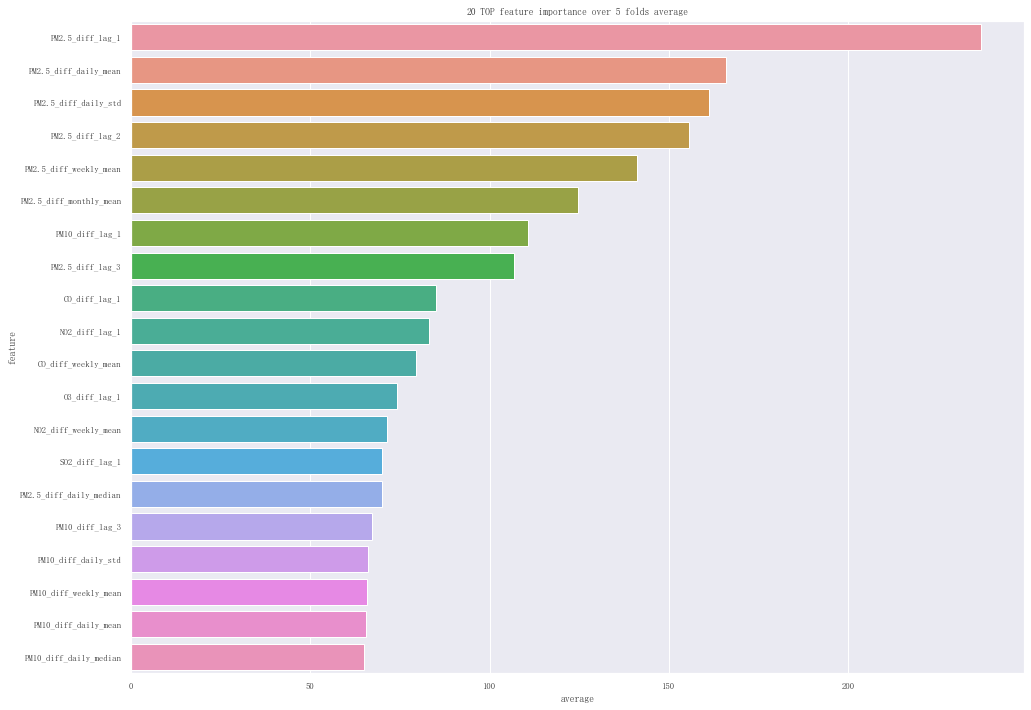

In [508]:
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(n_splits)]].mean(axis=1)
plt.figure(figsize=(16, 12))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(20), x='average', y='feature')
plt.title('20 TOP feature importance over {} folds average'.format(n_splits))

In [510]:
process_prediction(predicted,true_y,True)

process_prediction(test_predictions,testing_y,True)

In [516]:
print(f'In sample RMSE for LightGBM method is {np.sqrt(mean_squared_error(true_y["prediction"],true_y["PM2.5"]))}')
print(f'Out of sample RMSE for LightGBM method is {np.sqrt(mean_squared_error(testing_y["prediction"],testing_y["PM2.5"]))}')

In sample RMSE for LightGBM method is 16.684540173251534
Out of sample RMSE for LightGBM method is 15.705859226559783


- The prediction accuracy is futher improved as expected, since the gradient boosting tree-based method can handle very **complex decision boundaries** and we have added **more useful features** into the model.

### Model multiple locations as a whole

We now can use the same framework to build **35 individual models** for each single location. However, we can also take full advantage of our training data and build **a unified model** for all locations. This may result in an improvement in not only the overall accuracy, but also the individual accuracy for each location. 

In [533]:
alldata = pd.DataFrame()
allTarget = pd.DataFrame()
for l in train.columns[1:]:
    subset,true_y = process_one_location(train,l,take_log=True)
    alldata = pd.concat([alldata,subset])
    true_y['PM2.5_y'] = true_y['PM2.5'].shift(1) 
    allTarget = pd.concat([allTarget,true_y])
allTestdata = pd.DataFrame()
allTestTarget = pd.DataFrame()
for l in test_new.columns[1:]:
    subset,true_y = process_one_location(test_new,l,take_log=True)
    allTestdata = pd.concat([allTestdata,subset])
    true_y['PM2.5_y'] = true_y['PM2.5'].shift(1) 
    allTestTarget = pd.concat([allTestTarget,true_y])

We will be treating locations as a **categorical variable**. LightGBM can support categorical features pretty well. 

In [534]:
alldata_noTS = alldata.reset_index(drop=True)
allTarget_noTS = allTarget.reset_index(drop=True)

alldata_noTS['location'] = alldata_noTS['location'].astype('category')
encode_mapping = dict( enumerate(alldata_noTS['location'].cat.categories ) )
alldata_noTS['location'] = alldata_noTS['location'].cat.codes
allTestdata['location'] = allTestdata['location'].astype('category')
allTestdata['location'] = allTestdata['location'].cat.codes

##### Stratified K Fold Cross Validation

As discussed before, in addition to time series split,  we can also apply a K Fold Cross Validation for model evaluation. We will be using **a stratified K Fold CV** as an extension of the regular one. This is because we want to keep the ratio between locations the same in each fold as it is in the full dataset.

In [535]:
from sklearn.model_selection import StratifiedKFold

In [536]:
seed0=617
lgb_params = {
            'objective': 'regression',
            'subsample': 0.72,
            'subsample_freq': 5,
            'max_depth': -1,
            'learning_rate': 0.1,
            "boosting_type": "gbdt",
            "metric": 'rmse',
            "verbosity": -1,
            'feature_fraction': 0.5,
            'lambda_l1': 0.5,
            'lambda_l2': 1.0,
            'random_state': seed0,
            'feature_fraction_seed': seed0,
            'bagging_seed': seed0,
         }

In [537]:
def train_lgb(data,test,label,params,n_splits=5):
    skf = StratifiedKFold(n_splits)

    y_oof = np.zeros(data.shape[0])
    
    test_predictions = np.zeros(test.shape[0])

    feature_importances = pd.DataFrame()
    feature_importances['feature'] = data.columns[:-1]
    mean_score = []
    
    for fold_n, (train_index, valid_index) in enumerate(skf.split(data,label)):
        print(f'Fold: {fold_n+1}')
        X_train, X_valid = data.iloc[train_index].loc[:,data.columns!="target"],data.iloc[valid_index].loc[:,data.columns!="target"]
        y_train, y_valid = data.iloc[train_index].loc[:,"target"], data.iloc[valid_index].loc[:,"target"]

        dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature = ['location'])
        dvalid = lgb.Dataset(X_valid, label=y_valid, categorical_feature = ['location'])

        clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid],early_stopping_rounds = 50, verbose_eval=500)

        feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
        y_pred_valid = clf.predict(X_valid,num_iteration=clf.best_iteration)
        y_oof[valid_index] = y_pred_valid
        
        #Predict the test set       
        test_predictions += clf.predict(test.loc[:,data.columns!="target"],num_iteration=clf.best_iteration) / n_splits
        val_score = np.sqrt(mean_squared_error(y_pred_valid, y_valid))
        print(f'val rmse score is {val_score}')
        mean_score.append(val_score)

        del X_train, X_valid, y_train, y_valid
        gc.collect()

    print(f'mean rmse score over folds is {np.mean(mean_score)}')
    
    return y_oof, feature_importances,test_predictions

In [538]:
n_splits = 5
predicted, feature_importances,test_predictions = train_lgb(alldata_noTS,allTestdata,alldata_noTS['location'],lgb_params, n_splits)

Fold: 1
Training until validation scores don't improve for 50 rounds
[500]	training's rmse: 0.239664	valid_1's rmse: 0.253753
Early stopping, best iteration is:
[475]	training's rmse: 0.240648	valid_1's rmse: 0.253598
val rmse score is 0.25359824586230434
Fold: 2
Training until validation scores don't improve for 50 rounds
[500]	training's rmse: 0.233613	valid_1's rmse: 0.277892
Early stopping, best iteration is:
[656]	training's rmse: 0.228207	valid_1's rmse: 0.277207
val rmse score is 0.2772070929300053
Fold: 3
Training until validation scores don't improve for 50 rounds
[500]	training's rmse: 0.239134	valid_1's rmse: 0.252686
[1000]	training's rmse: 0.22412	valid_1's rmse: 0.250601
Early stopping, best iteration is:
[1316]	training's rmse: 0.21683	valid_1's rmse: 0.249968
val rmse score is 0.24996760161826984
Fold: 4
Training until validation scores don't improve for 50 rounds
[500]	training's rmse: 0.231275	valid_1's rmse: 0.284017
Early stopping, best iteration is:
[776]	training'

Text(0.5, 1.0, '20 TOP feature importance over 5 folds average')

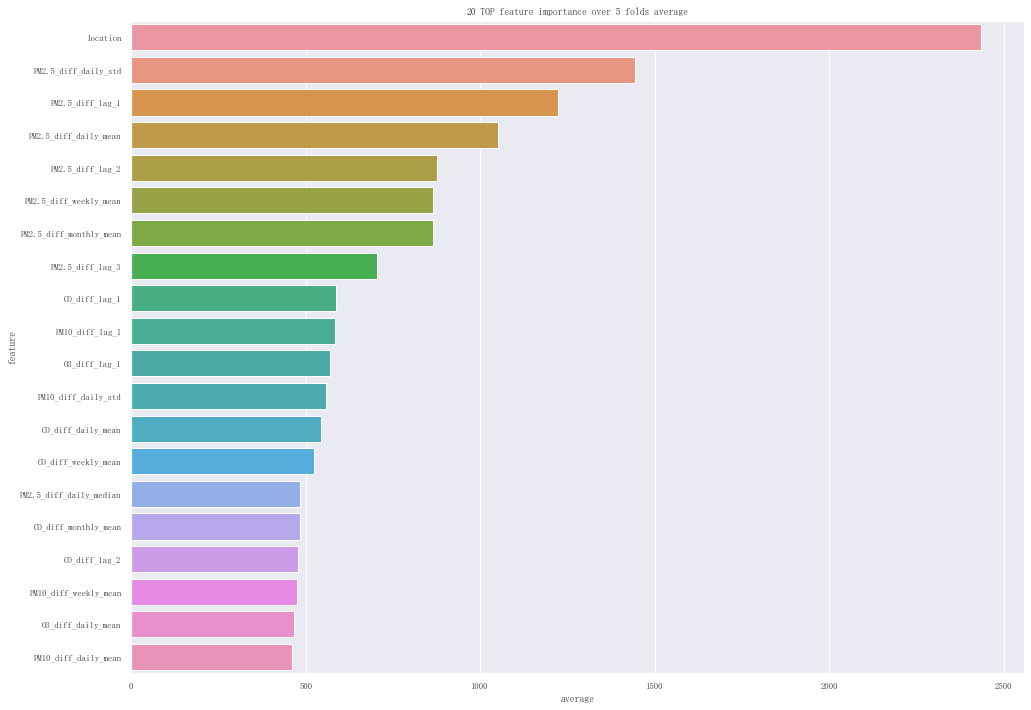

In [540]:
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(n_splits)]].mean(axis=1)
plt.figure(figsize=(16, 12))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(20), x='average', y='feature')
plt.title('20 TOP feature importance over {} folds average'.format(n_splits))

- As we can see, location serves as a very important feature. 

In [541]:
process_prediction(predicted,allTarget_noTS,True)
process_prediction(test_predictions,allTestTarget,True)

In [542]:
print(f'In sample RMSE for LightGBM method is {np.sqrt(mean_squared_error(allTarget_noTS["prediction"],allTarget_noTS["PM2.5"]))}')
print(f'Out of sample RMSE for LightGBM method is {np.sqrt(mean_squared_error(allTestTarget["prediction"],allTestTarget["PM2.5"]))}')

In sample RMSE for LightGBM method is 17.651118648003337
Out of sample RMSE for LightGBM method is 17.70353344589615


In [545]:
print('In sample RMSE for each location is')
display(allTarget_noTS.groupby(allTarget_noTS.location).apply(
    lambda x: mean_squared_error(x['PM2.5'], x['prediction']) ** .5))

In sample RMSE for each location is


location
万寿西宫    16.763582
万柳      15.339958
东四      16.611653
东四环     17.075942
东高村     16.337971
丰台花园    17.700340
云岗      16.068050
亦庄      19.909570
八达岭     12.115185
农展馆     17.218090
前门      23.525393
北部新区    15.889205
南三环     17.438521
古城      16.225983
大兴      19.291404
天坛      15.000944
奥体中心    16.411533
官园      15.143315
定陵      16.471401
密云      13.973327
密云水库    11.515694
平谷      19.082886
延庆      17.496509
怀柔      14.738813
房山      20.791876
昌平      16.445294
植物园     14.799140
榆垡      23.693941
永乐店     23.441957
永定门内    18.149617
琉璃河     24.313035
西直门北    19.552954
通州      19.023457
门头沟     14.188667
顺义      16.977273
dtype: float64

In [546]:
print('Out of sample RMSE for each location is')
display(allTestTarget.groupby(allTestTarget.location).apply(
    lambda x: mean_squared_error(x['PM2.5'], x['prediction']) ** .5))

Out of sample RMSE for each location is


location
万寿西宫    21.756583
万柳      14.050126
东四      17.529439
东四环     16.177885
东高村     17.925522
丰台花园    15.827840
云岗      17.477613
亦庄      15.306458
八达岭     10.951259
农展馆     16.538105
前门      19.999818
北部新区    16.166949
南三环     18.704559
古城      18.294096
大兴      16.871133
天坛      15.099127
奥体中心    15.915147
官园      15.622520
定陵      12.267580
密云      13.738959
密云水库     9.503711
平谷      22.749668
延庆      19.082877
怀柔      16.520401
房山      18.422696
昌平      15.509843
植物园     13.371227
榆垡      30.255596
永乐店     18.151465
永定门内    19.002371
琉璃河     21.163680
西直门北    23.776772
通州      17.697341
门头沟     18.165455
顺义      16.145386
dtype: float64

- We see that in sample RMSE score and out of sample RMSE score for 万柳 further reduce to 15.339958 and 14.050126. This is a significant improvement compared to our previous results. 

### Apply a clustering algorithm

In [577]:
alldata = pd.DataFrame()
allTarget = pd.DataFrame()
for l in train.columns[1:]:
    subset,true_y = process_one_location(train,l,take_log=True)
    alldata = pd.concat([alldata,subset])
    true_y['PM2.5_y'] = true_y['PM2.5'].shift(1) 
    allTarget = pd.concat([allTarget,true_y])
allTestdata = pd.DataFrame()
allTestTarget = pd.DataFrame()
for l in test_new.columns[1:]:
    subset,true_y = process_one_location(test_new,l,take_log=True)
    allTestdata = pd.concat([allTestdata,subset])
    true_y['PM2.5_y'] = true_y['PM2.5'].shift(1) 
    allTestTarget = pd.concat([allTestTarget,true_y])

Now that we train a unified model for all locations, we are interested in learning more about the **relationship between different locations**. If we can cluster the locations into several groups, and we calculate some **grouped statistics** as new features, it may further improve our model.\
We would expect locations that are close to each other to be clustered into one group. Also densely populated locations and lightly populated locations should be clustered into different groups. 

<AxesSubplot:xlabel='None-location', ylabel='None-location'>

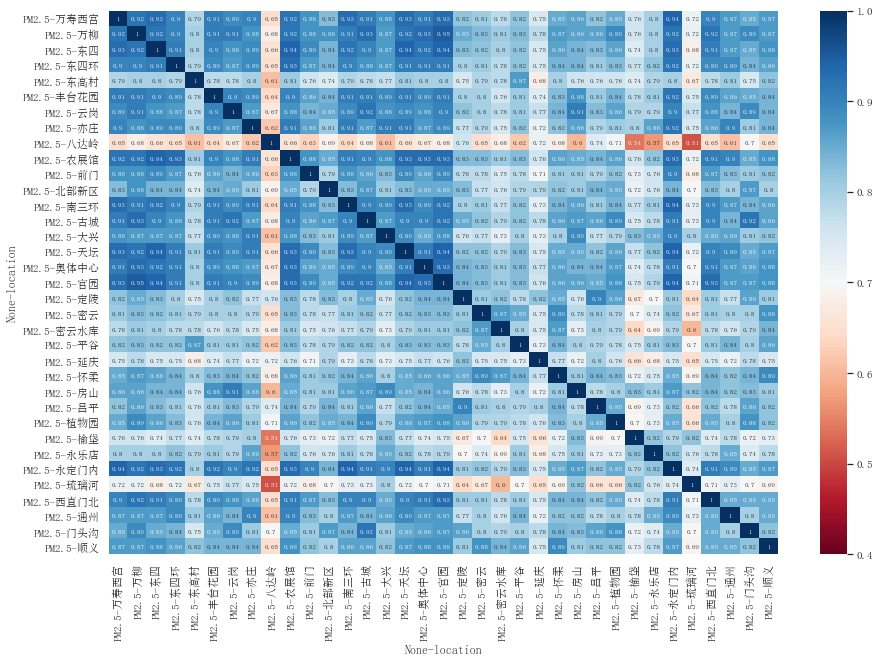

In [578]:
corr_data = allTarget[["PM2.5","location"]].pivot(columns='location')
corr = allTarget[["PM2.5","location"]].pivot(columns='location').corr()
plt.figure(figsize=(15,10))
sns.set(font="SimSun")
sns.heatmap(round(corr,2), cmap='RdBu', annot=True, 
            annot_kws={"size": 7}, vmin=0.4, vmax=1)

- We will be applying the hierarchical clustering method to the correlation matrix. Here the distance is defined as $d=\sqrt{2(1-\rho)}$.

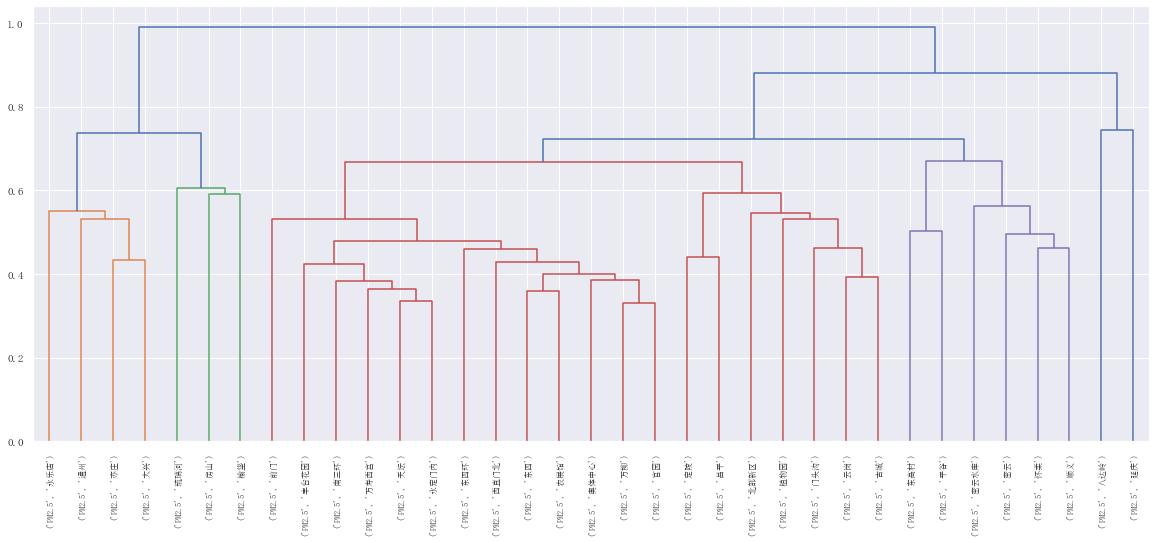

In [579]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
plt.figure(figsize=(20,8))
sns.set(font="SimSun",font_scale=1)
dissimilarity = np.sqrt(2*(1 - corr))
Z = linkage(squareform(dissimilarity), 'complete')

dendrogram(Z, labels=corr_data.columns, orientation='top', 
           leaf_rotation=90);

-  We can group 35 locations into 5 clusters, according to the dendrogram.
- The clusters also make sense. For example, 永乐店，通州，亦庄 and 大兴 are clusted into one group, as they all sit in the **southeastern** suburb of the city. Also 八达岭 and 延庆 are clustered together as they are located in the **northwestern** suburb.

In [580]:
labels = fcluster(Z, t=5, criterion='maxclust')

labels_order = np.argsort(labels)

for idx, i in enumerate(corr_data.columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(corr_data[i])
    else:
        df_to_append = pd.DataFrame(corr_data[i])
        clustered = pd.concat([clustered, df_to_append], axis=1)

- We now have the **clustered correlation matrix**.

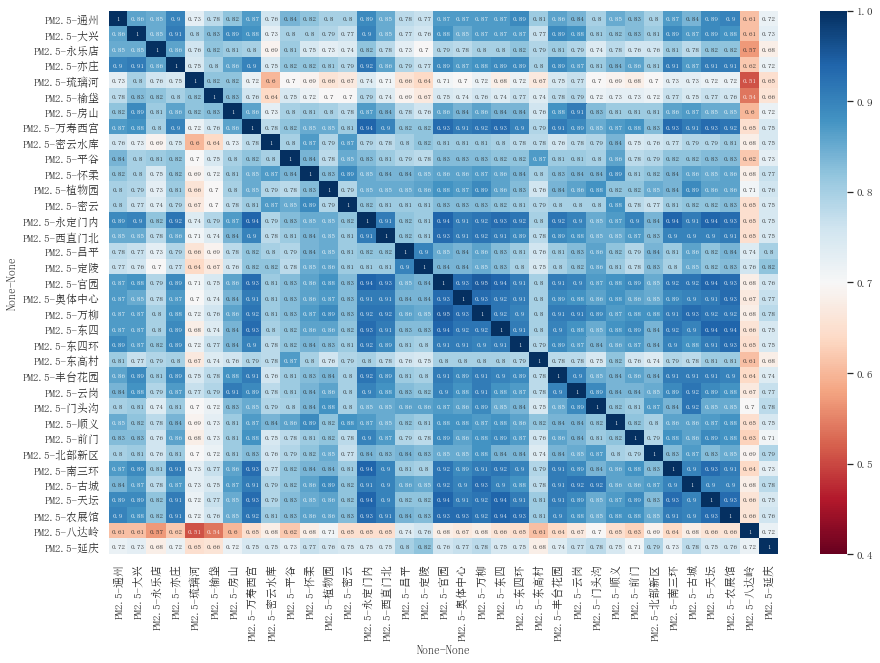

In [581]:
plt.figure(figsize=(15,10))
sns.set(font="SimSun",font_scale=1)
correlations = clustered.corr()
sns.heatmap(round(correlations,2), cmap='RdBu', annot=True, 
            annot_kws={"size": 7}, vmin=0.4, vmax=1);

- We build clustered statistics according to the location label. The new features would have a suffix like '_c1'

In [582]:
label_map = {c[1]:labels[i] for i,c in enumerate(corr_data.columns)}
def get_cluster_stats(labels,data):
    data = data.copy(deep=True)
    data['cluster'] = data['location'].map(lambda x: labels[x])
    tmp = data.groupby([data.index,'cluster'],as_index=False).mean()
    tmp = tmp.set_index(data.groupby([data.index,'cluster']).mean().index.get_level_values(0))
    newdf = pd.DataFrame()
    for c in set(tmp.cluster):
        cluster = tmp[tmp['cluster']==c]
        cluster.columns = [f'{col}_c{c}' for col in tmp.columns]
        newdf = pd.concat([newdf, cluster],axis=1)
    newdf = newdf[[col for col in newdf.columns if 'PM' in col]]
    newdf = pd.merge(newdf,data,left_index=True,right_index=True)
    newdf.drop(columns=['cluster'],inplace=True)
    del tmp
    gc.collect()
    return newdf

In [583]:
alldata = get_cluster_stats(label_map,alldata)
allTestdata = get_cluster_stats(label_map,allTestdata)
alldata_noTS = alldata.reset_index(drop=True)
allTarget_noTS = pd.merge(alldata,allTarget,left_on=[alldata.index,'location'],right_on=[allTarget.index,'location'])[["PM2.5","PM2.5_y","location"]]
#rearrange allTestTarget after clustering
allTestTarget['date'] = allTestTarget.index
allTestTarget = pd.merge(allTestdata,allTestTarget,left_on=[allTestdata.index,'location'],right_on=[allTestTarget.index,'location'])[["PM2.5","PM2.5_y","location","date"]]
allTestTarget = allTestTarget.set_index(allTestTarget.date)
allTestTarget = allTestTarget.drop(columns='date')
alldata_noTS['location'] = alldata_noTS['location'].astype('category')
encode_mapping = dict( enumerate(alldata_noTS['location'].cat.categories ) )
alldata_noTS['location'] = alldata_noTS['location'].cat.codes
allTestdata['location'] = allTestdata['location'].astype('category')
allTestdata['location'] = allTestdata['location'].cat.codes

In [584]:
seed0=617
lgb_params = {
            'objective': 'regression',
            'subsample': 0.72,
            'subsample_freq': 5,
            'max_depth': -1,
            'learning_rate': 0.1,
            "boosting_type": "gbdt",
            "metric": 'rmse',
            "verbosity": -1,
            'feature_fraction': 0.5,
            'lambda_l1': 0.5,
            'lambda_l2': 1.0,
            'random_state': seed0,
            'feature_fraction_seed': seed0,
            'bagging_seed': seed0,
         }


In [585]:
n_splits = 5
predicted, feature_importances,test_predictions = train_lgb(alldata_noTS,allTestdata,alldata_noTS['location'],lgb_params, n_splits)

Fold: 1
Training until validation scores don't improve for 50 rounds
[500]	training's rmse: 0.214651	valid_1's rmse: 0.229411
Early stopping, best iteration is:
[596]	training's rmse: 0.210638	valid_1's rmse: 0.228989
val rmse score is 0.22898911816309764
Fold: 2
Training until validation scores don't improve for 50 rounds
[500]	training's rmse: 0.208529	valid_1's rmse: 0.254472
Early stopping, best iteration is:
[685]	training's rmse: 0.201159	valid_1's rmse: 0.253739
val rmse score is 0.2537393892655286
Fold: 3
Training until validation scores don't improve for 50 rounds
[500]	training's rmse: 0.213101	valid_1's rmse: 0.233381
Early stopping, best iteration is:
[837]	training's rmse: 0.200754	valid_1's rmse: 0.232015
val rmse score is 0.23201479766062252
Fold: 4
Training until validation scores don't improve for 50 rounds
[500]	training's rmse: 0.205712	valid_1's rmse: 0.26236
Early stopping, best iteration is:
[757]	training's rmse: 0.196067	valid_1's rmse: 0.261105
val rmse score i

Text(0.5, 1.0, '20 TOP feature importance over 5 folds average')

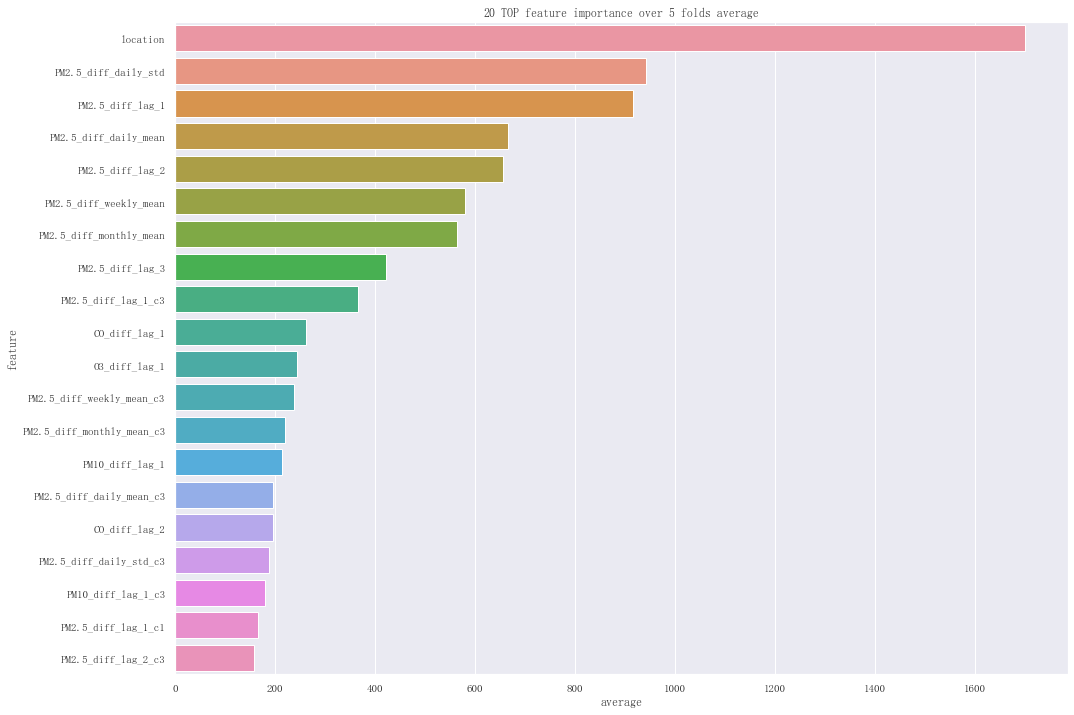

In [586]:
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(n_splits)]].mean(axis=1)
plt.figure(figsize=(16, 12))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(20), x='average', y='feature')
plt.title('20 TOP feature importance over {} folds average'.format(n_splits))

- We see that features with suffix like '_c3' contribute a lot in terms of feature importance. 

In [587]:
process_prediction(predicted,allTarget_noTS,True)
process_prediction(test_predictions,allTestTarget,True)

In [588]:
print(f'In sample RMSE for LightGBM method is {np.sqrt(mean_squared_error(allTarget_noTS["prediction"],allTarget_noTS["PM2.5"]))}')
print(f'Out of sample RMSE for LightGBM method is {np.sqrt(mean_squared_error(allTestTarget["prediction"],allTestTarget["PM2.5"]))}')

In sample RMSE for LightGBM method is 16.780742438091703
Out of sample RMSE for LightGBM method is 16.717852627474034


In [589]:
print('In sample RMSE for each location is')
display(allTarget_noTS.groupby(allTarget_noTS.location).apply(
    lambda x: mean_squared_error(x['PM2.5'], x['prediction']) ** .5))

In sample RMSE for each location is


location
万寿西宫    15.119440
万柳      13.926285
东四      14.942066
东四环     15.412410
东高村     15.805362
丰台花园    16.572145
云岗      14.480724
亦庄      21.855154
八达岭     12.063859
农展馆     16.142115
前门      20.145207
北部新区    14.913228
南三环     15.881809
古城      14.865170
大兴      17.916179
天坛      13.385407
奥体中心    15.616832
官园      13.406550
定陵      15.930730
密云      13.479756
密云水库    11.089659
平谷      18.476194
延庆      18.176567
怀柔      13.811178
房山      19.385858
昌平      15.614757
植物园     13.783931
榆垡      23.292021
永乐店     25.131989
永定门内    16.464641
琉璃河     23.906652
西直门北    18.169609
通州      17.939186
门头沟     13.174912
顺义      16.014605
dtype: float64

In [590]:
print('Out of sample RMSE for each location is')
display(allTestTarget.groupby(allTestTarget.location).apply(
    lambda x: mean_squared_error(x['PM2.5'], x['prediction']) ** .5))

Out of sample RMSE for each location is


location
万寿西宫    19.706730
万柳      13.353009
东四      16.764128
东四环     14.304855
东高村     16.855863
丰台花园    14.811303
云岗      17.182517
亦庄      14.051014
八达岭     11.272012
农展馆     14.400145
前门      18.337050
北部新区    14.065405
南三环     16.720813
古城      16.703080
大兴      16.811731
天坛      12.984476
奥体中心    14.950846
官园      13.506071
定陵      11.728483
密云      13.219997
密云水库     9.414640
平谷      22.556738
延庆      19.129566
怀柔      17.356584
房山      18.526606
昌平      14.026537
植物园     12.297011
榆垡      29.610194
永乐店     17.263837
永定门内    16.687979
琉璃河     20.212738
西直门北    22.220706
通州      17.315566
门头沟     16.820888
顺义      15.493405
dtype: float64

- We see that in sample RMSE score and out of sample RMSE score for 万柳 further reduce to 13.926285 and 13.353009. This is another substaintial improvement on top of our existing model.

### Conclusion and future work

To summarize what we have done so far: 
- First we focus on one single location. 
- We use RMSE as the performance metrics.
- We start from a very naive model where we use last hour PM2.5 level to predict next hour level. 
- We build an ARIMA(2,1,0) model according to the ACF and PACF plots.
- We add other pollutants as exogenous variables into the ARIMA model. We tranform the data first to ensure stationarity.
- By feature engineering, we get more useful features such as monthly rolling window average, which account for the monthly patterns over the year.
- We build a LightGBM model using all those features.
- We move one step further to build a unified LightGBM model using data from all locations where we treat location as a categorical variable. 
- We also group the locations into different clusters according to their distance and population implied by the correlation matrix. 
- The grouped statistics for each cluster substaintially improve our model performance.

Here are the RMSE scores for '万柳'. Note that we do have predictions for each location from our final LightGBM model. For clear comparison, we only display '万柳':

| Model | In sample | Out of sample |
| :- | -: | :-: |
| Naive | 18.10 | 17.87
| ARIMA(2,1,0) | 17.52 | 17.20
| ARIMA with exog |17.46 | 16.61
| single LightGBM | 16.68 | 15.71
| unified LightGBM | 15.34 | 14.05
| unified LightGBM with clusters | 13.93 | 13.35

Some takeaways from the project: 
- The dataset has great predictive power for next hour PM2.5: naive model works well.
- Reasonably making new features out of the dataset could significantly improve model performance.
- There are clear trends and patterns due to the intrinsic nature of the data. For example, PM2.5 level has seasonal difference, lower in summer and higher in winter. Also there could be a downward trend in PM2.5 level due to the city's efforts to improve air quality. We need to handle trends and seasonality carefully.
- Building a unified model for all locations will outperform each single individual model. This is because we can make the best use of a complete training set instead of a part of it. 
- By clustering the data according to their physical distance, we could result in a better model performance. Once again, the intrinsic nature of the data matters. 

For future works, we could tune the hyperparameters for our LightGBM model for a better performance. We could also do some explorations in some other methods which can predict time series, e.g. LSTM, as such network is designed to handle sequence dependency.

## Thanks for the time! 